In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error
import s3fs
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
import seaborn as sns
sns.set_style('whitegrid')
import pymc3 as pm
import arviz as az
import warnings
warnings.filterwarnings('ignore')

In [2]:
location_train = 's3://mozbi-sr-data-science/data/moz_customer_data_train.csv'
location_test = 's3://mozbi-sr-data-science/data/moz_customer_data_test.csv'
d = pd.read_csv(location_train, sep='|'); d.shape
t = pd.read_csv(location_test, sep='|'); t.shape

#----------------------------------------------------
# Renaming columns for coding ease
#----------------------------------------------------
d = d.rename(columns={'industry':'ind',
                      'geography':'geo',
                     'most_common_browser':'browser',
                     'session_time_prior_month_seconds':'time',
                     'prior_month_paid':'paid'})

#----------------------------------------------------
# Transformations
#----------------------------------------------------
d['time_transformed'] = np.power(d['time'], 1/10)

y_boxcox, y_lambda = stats.boxcox(d['paid'])
d['paid_boxcox'] = y_boxcox
print(f'Rounded lambda for boxcox transformation is {y_lambda:.4f}')
d.head()

Rounded lambda for boxcox transformation is 1.1243


id               ind     geo  browser  time        paid  \
0  1585597623               NaN      GB   Chrome  1092   25.607595   
1  6531970533        healthcare      US  Firefox  2480  115.579494   
2  8443866239       health care  Canada   Chrome  1671   89.462246   
3  1480089466        healthcare  Greece   Chrome   465   33.836123   
4  6170390298  marketing agency     USA  Firefox  1477  129.394415   

   time_transformed  paid_boxcox  
0          2.012900    33.190347  
1          2.184968   184.606107  
2          2.100379   138.192452  
3          1.848184    45.727604  
4          2.074618   209.711785

In [3]:
#------------------------------------------------------------------
# Variables and function for creating groups based on session time
#------------------------------------------------------------------
# The following variables were set based on analysis and plots seen below using the root 10 transformation for session time
time_group_low = 1.65
time_group_mid = 1.8

def time_grouping(x):
    group = 0
    if x > time_group_mid:
        group = 2
    elif (x > time_group_low) & (x <= time_group_mid):
        group = 1
    return group

## 1. Please provide a general description of the data. This may involve descriptive statistics, graphs, or other presentation methods of your choice.

### Comments


*Cleaning*

Below we will see that there are multiple conventions used for the naming of industry and geograph. These are consolidated to have a single name used for each unique value.

*Distributions*

We are going to be performing linear regression, so below we are taking a look at whether paid looks like a normal distribution through histograms and qqplots. We will also break distributions down by geography and industry.

There is one continuous predictor in the data set, "session_time_prior_month_seconds", we will look at this distrubtion and explore its relationship with how much is paid as well as exploring possible transformations to help with finding a linear relationship.

*Exploratory Data Analysis (EDA) Conclusions*

The amount paid is pretty close to a normal distribution when broken down by geography and industry. A transformation of paid is likely not necessary. The distribution of session time looks like an exponential distribution and its relationship with paid shows a curvature. Transforming this predictor using a root of 10 creates a linear relationship when we seperate the data into multiple groups of session time. Using a root of 10 was found using cross validation of multiple options for roots and also a log transformation. The first and second groups with lower times have flat relationships, essentially a slope of zero based on visual inspection, and the third group with higher sessions times have a nearly straight line positive relationship, meaning that higher session times equate to higher amounts paid.

In [4]:
display(d.head())
d.info()

id               ind     geo  browser  time        paid  \
0  1585597623               NaN      GB   Chrome  1092   25.607595   
1  6531970533        healthcare      US  Firefox  2480  115.579494   
2  8443866239       health care  Canada   Chrome  1671   89.462246   
3  1480089466        healthcare  Greece   Chrome   465   33.836123   
4  6170390298  marketing agency     USA  Firefox  1477  129.394415   

   time_transformed  paid_boxcox  
0          2.012900    33.190347  
1          2.184968   184.606107  
2          2.100379   138.192452  
3          1.848184    45.727604  
4          2.074618   209.711785

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48000 entries, 0 to 47999
Data columns (total 8 columns):
id                  48000 non-null int64
ind                 40636 non-null object
geo                 48000 non-null object
browser             48000 non-null object
time                48000 non-null int64
paid                48000 non-null float64
time_transformed    48000 non-null float64
paid_boxcox         48000 non-null float64
dtypes: float64(3), int64(2), object(3)
memory usage: 2.9+ MB


In [5]:
# We see below that there are multiple versions of the same industry
d['ind'].unique()

array([nan, 'healthcare', 'health care', 'marketing agency',
       'Marketing Agency', 'software', 'unknown', 'unk', 'mktg agency'],
      dtype=object)

array(['unknown', 'healthcare', 'marketing agency', 'software'],
      dtype=object)

marketing agency    18095
unknown             12063
healthcare          11963
software             5879
Name: ind, dtype: int64

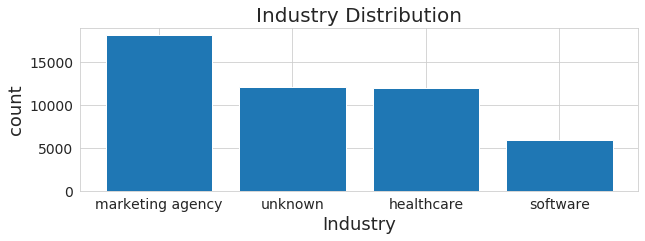

In [6]:
#--------------------------------------------------------------
# Cleaning up industry data
#--------------------------------------------------------------
d['ind'] = d['ind'].replace(to_replace=['health care'], value='healthcare')
d['ind'] = d['ind'].replace(to_replace=['Marketing Agency', 'mktg agency'], value='marketing agency')
d['ind'] = d['ind'].replace(to_replace=['unk'], value='unknown')
d['ind'] = d['ind'].fillna(value='unknown')
display(d['ind'].unique())
display(d['ind'].value_counts())
figsize(10,3)
plt.bar(d['ind'].value_counts().index, d['ind'].value_counts())
plt.title('Industry Distribution', fontsize=20)
plt.ylabel('count', fontsize=18)
plt.xlabel('Industry', fontsize=18)
plt.tick_params(labelsize=14)
plt.show()

In [7]:
# We see below that there are multiple versions of the same geography
d['geo'].unique()

array(['GB', 'US', 'Canada', 'Greece', 'USA', 'CA', 'America',
       'United States', 'Esp', 'UK', 'India', 'Pakistan',
       'United Kingdom', 'England', 'France', 'Spain'], dtype=object)

array(['UK', 'US', 'CA', 'Greece', 'Spain', 'India', 'Pakistan', 'France'],
      dtype=object)

US          21457
CA          10709
UK           5260
Spain        3483
Pakistan     1797
Greece       1782
India        1773
France       1739
Name: geo, dtype: int64

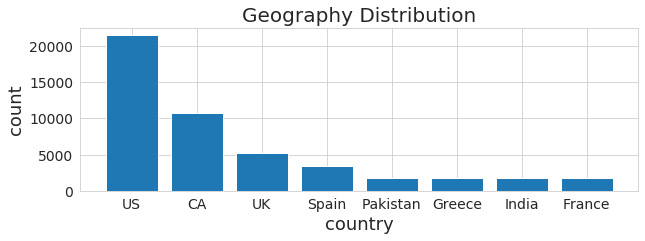

In [8]:
#--------------------------------------------------------------
# Cleaning up geography data
#--------------------------------------------------------------
d['geo'] = d['geo'].replace(to_replace=['USA', 'America', 'United States'], value='US')
d['geo'] = d['geo'].replace(to_replace=['Canada'], value='CA')
d['geo'] = d['geo'].replace(to_replace=['GB', 'United Kingdom', 'England'], value='UK')
d['geo'] = d['geo'].replace(to_replace=['Esp'], value='Spain')
display(d['geo'].unique())
display(d['geo'].value_counts())
figsize(10,3)
plt.bar(d['geo'].value_counts().index, d['geo'].value_counts())
plt.title('Geography Distribution', fontsize=20)
plt.ylabel('count', fontsize=18)
plt.xlabel('country', fontsize=18)
plt.tick_params(labelsize=14)
plt.show()

Chrome     24194
Safari      7950
IE          7935
Firefox     7921
Name: browser, dtype: int64

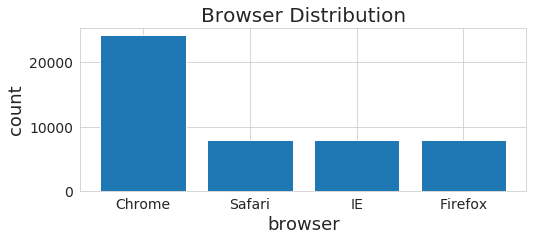

In [9]:
display(d['browser'].value_counts())
figsize(8,3)
plt.bar(d['browser'].value_counts().index, d['browser'].value_counts())
plt.title('Browser Distribution', fontsize=20)
plt.ylabel('count', fontsize=18)
plt.xlabel('browser', fontsize=18)
plt.tick_params(labelsize=14)
plt.show()

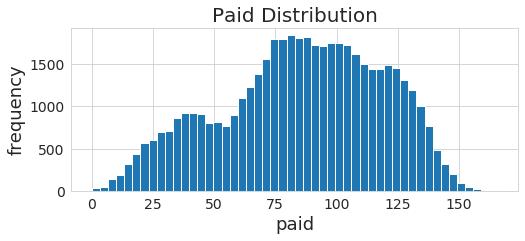

In [10]:
figsize(8,3)
plt.hist(d['paid'], bins=50)
plt.title('Paid Distribution', fontsize=20)
plt.ylabel('frequency', fontsize=18)
plt.xlabel('paid', fontsize=18)
plt.tick_params(labelsize=14)
plt.show()

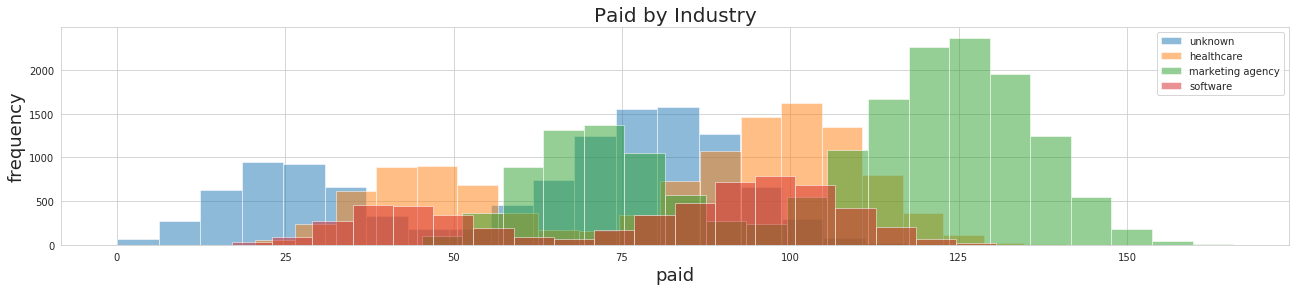

In [11]:
ind = d['ind'].unique()
figsize(22,4)
for i in ind:
    d_temp = d[d['ind']==i]
    plt.hist(d_temp['paid'], bins=20, label=i, alpha=0.5)
plt.title('Paid by Industry', fontsize=20)
plt.xlabel('paid', fontsize=18)
plt.ylabel('frequency', fontsize=18)
plt.legend()
plt.show()

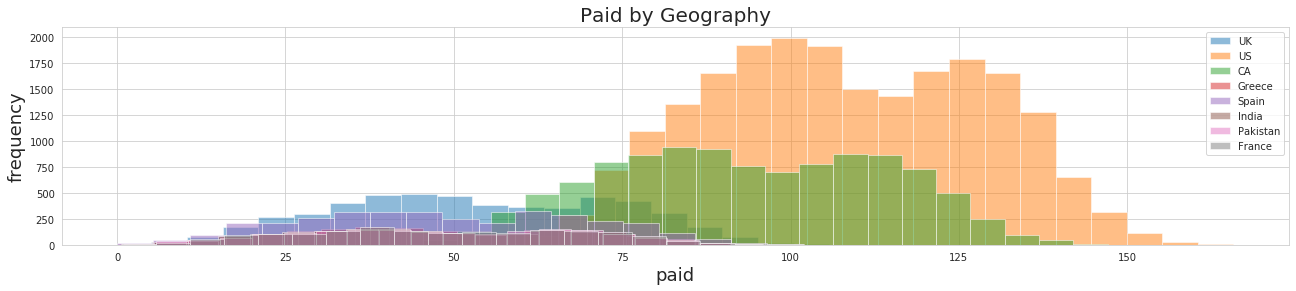

In [12]:
geo = d['geo'].unique()
figsize(22,4)
for i in geo:
    d_temp = d[d['geo']==i]
    plt.hist(d_temp['paid'], bins=20, label=i, alpha=0.5)
plt.title('Paid by Geography', fontsize=20)
plt.xlabel('paid', fontsize=18)
plt.ylabel('frequency', fontsize=18)
plt.legend()
plt.show()

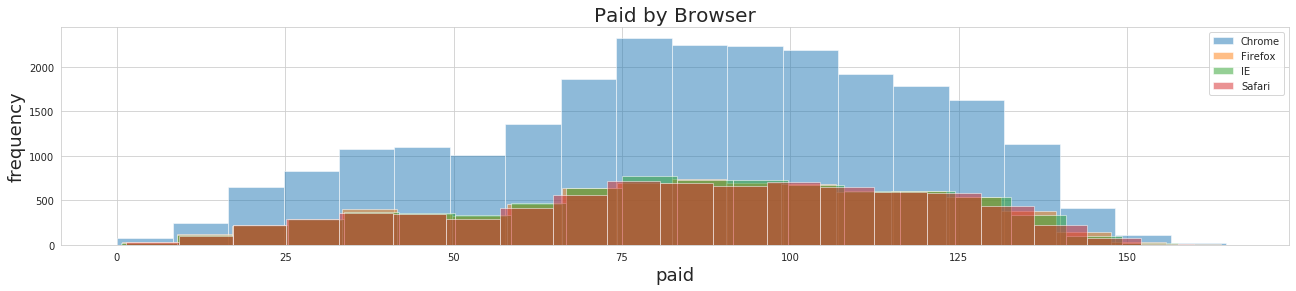

In [13]:
browser = d['browser'].unique()
figsize(22,4)
for i in browser:
    d_temp = d[d['browser']==i]
    plt.hist(d_temp['paid'], bins=20, label=i, alpha=0.5)
plt.title('Paid by Browser', fontsize=20)
plt.xlabel('paid', fontsize=18)
plt.ylabel('frequency', fontsize=18)
plt.legend()
plt.show()

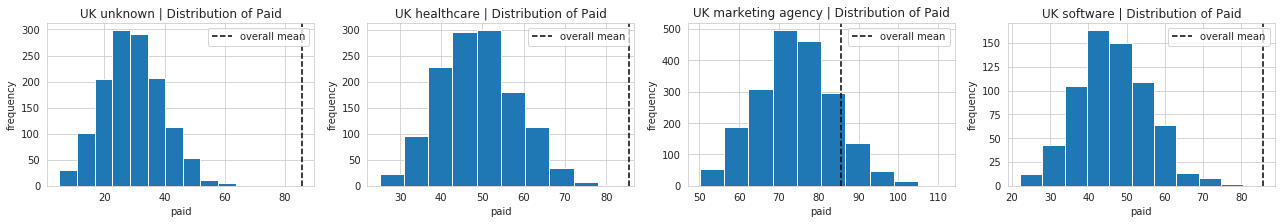

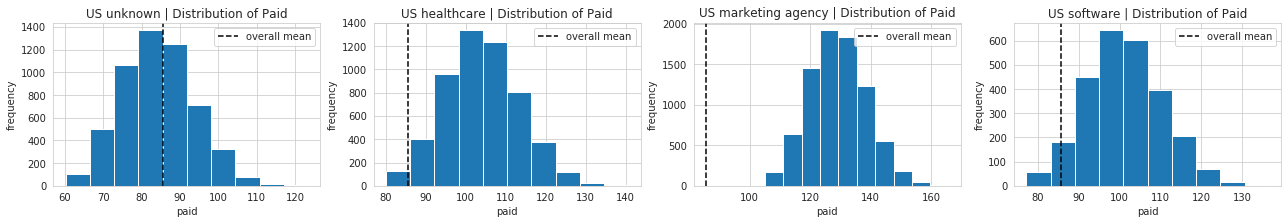

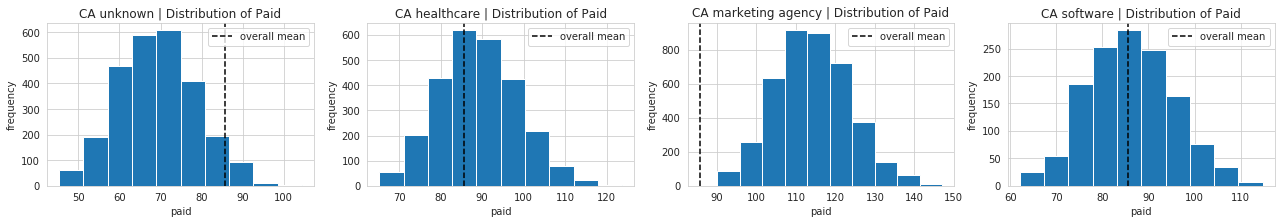

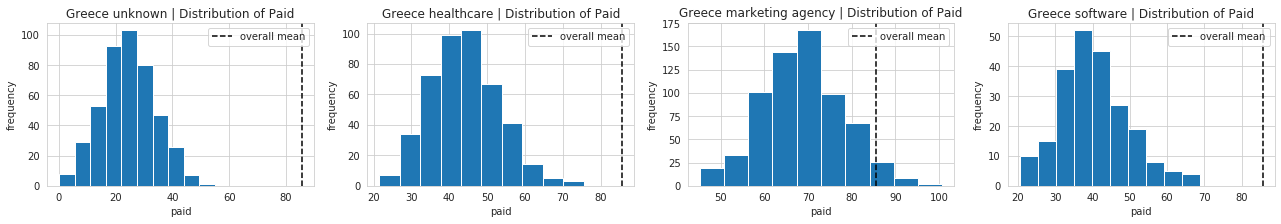

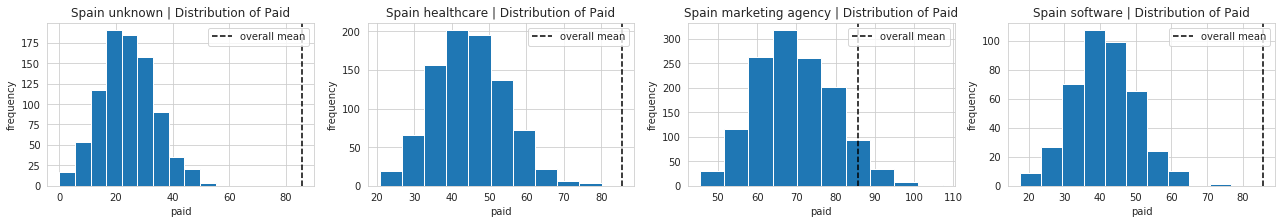

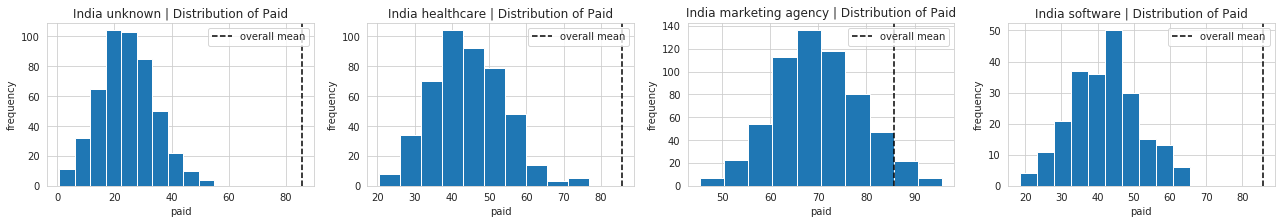

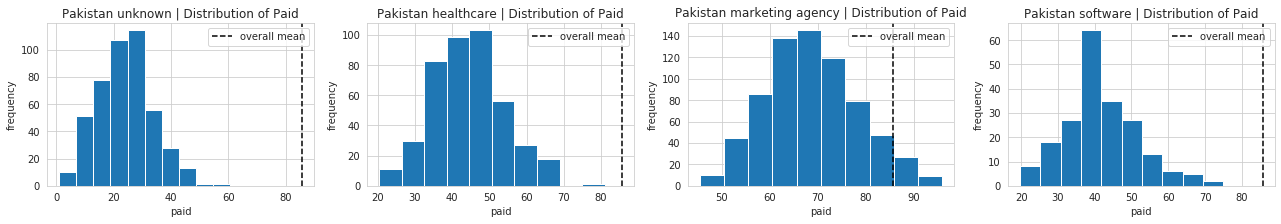

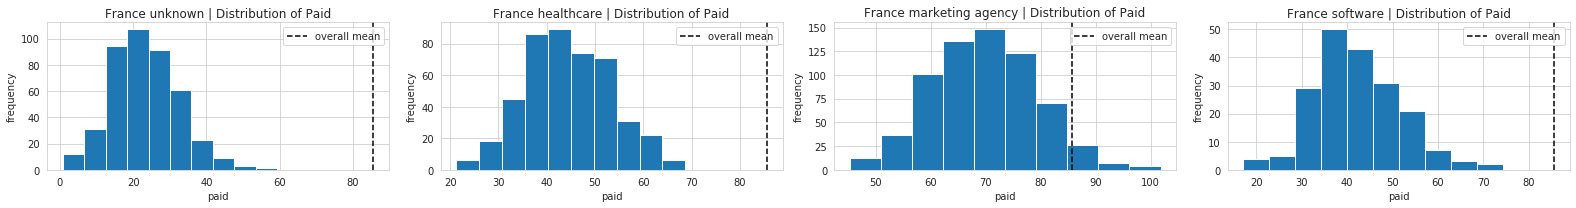

In [14]:
for g in d['geo'].unique():
    d_temp = d[d['geo']==g]
    f, ax = plt.subplots(1,len(d['ind'].unique()), figsize=[22,3])
    for idx, ind in enumerate(d['ind'].unique()):
        d_ind = d_temp[d_temp['ind']==ind]
        ax[idx].hist(d_ind['paid'])
        ax[idx].axvline(d['paid'].mean(), ls='--', color='k', label='overall mean')
        ax[idx].set_title(g + ' ' + ind + ' | Distribution of Paid')
        ax[idx].set_xlabel('paid')
        ax[idx].set_ylabel('frequency')
        ax[idx].legend(loc='upper right')
plt.tight_layout()

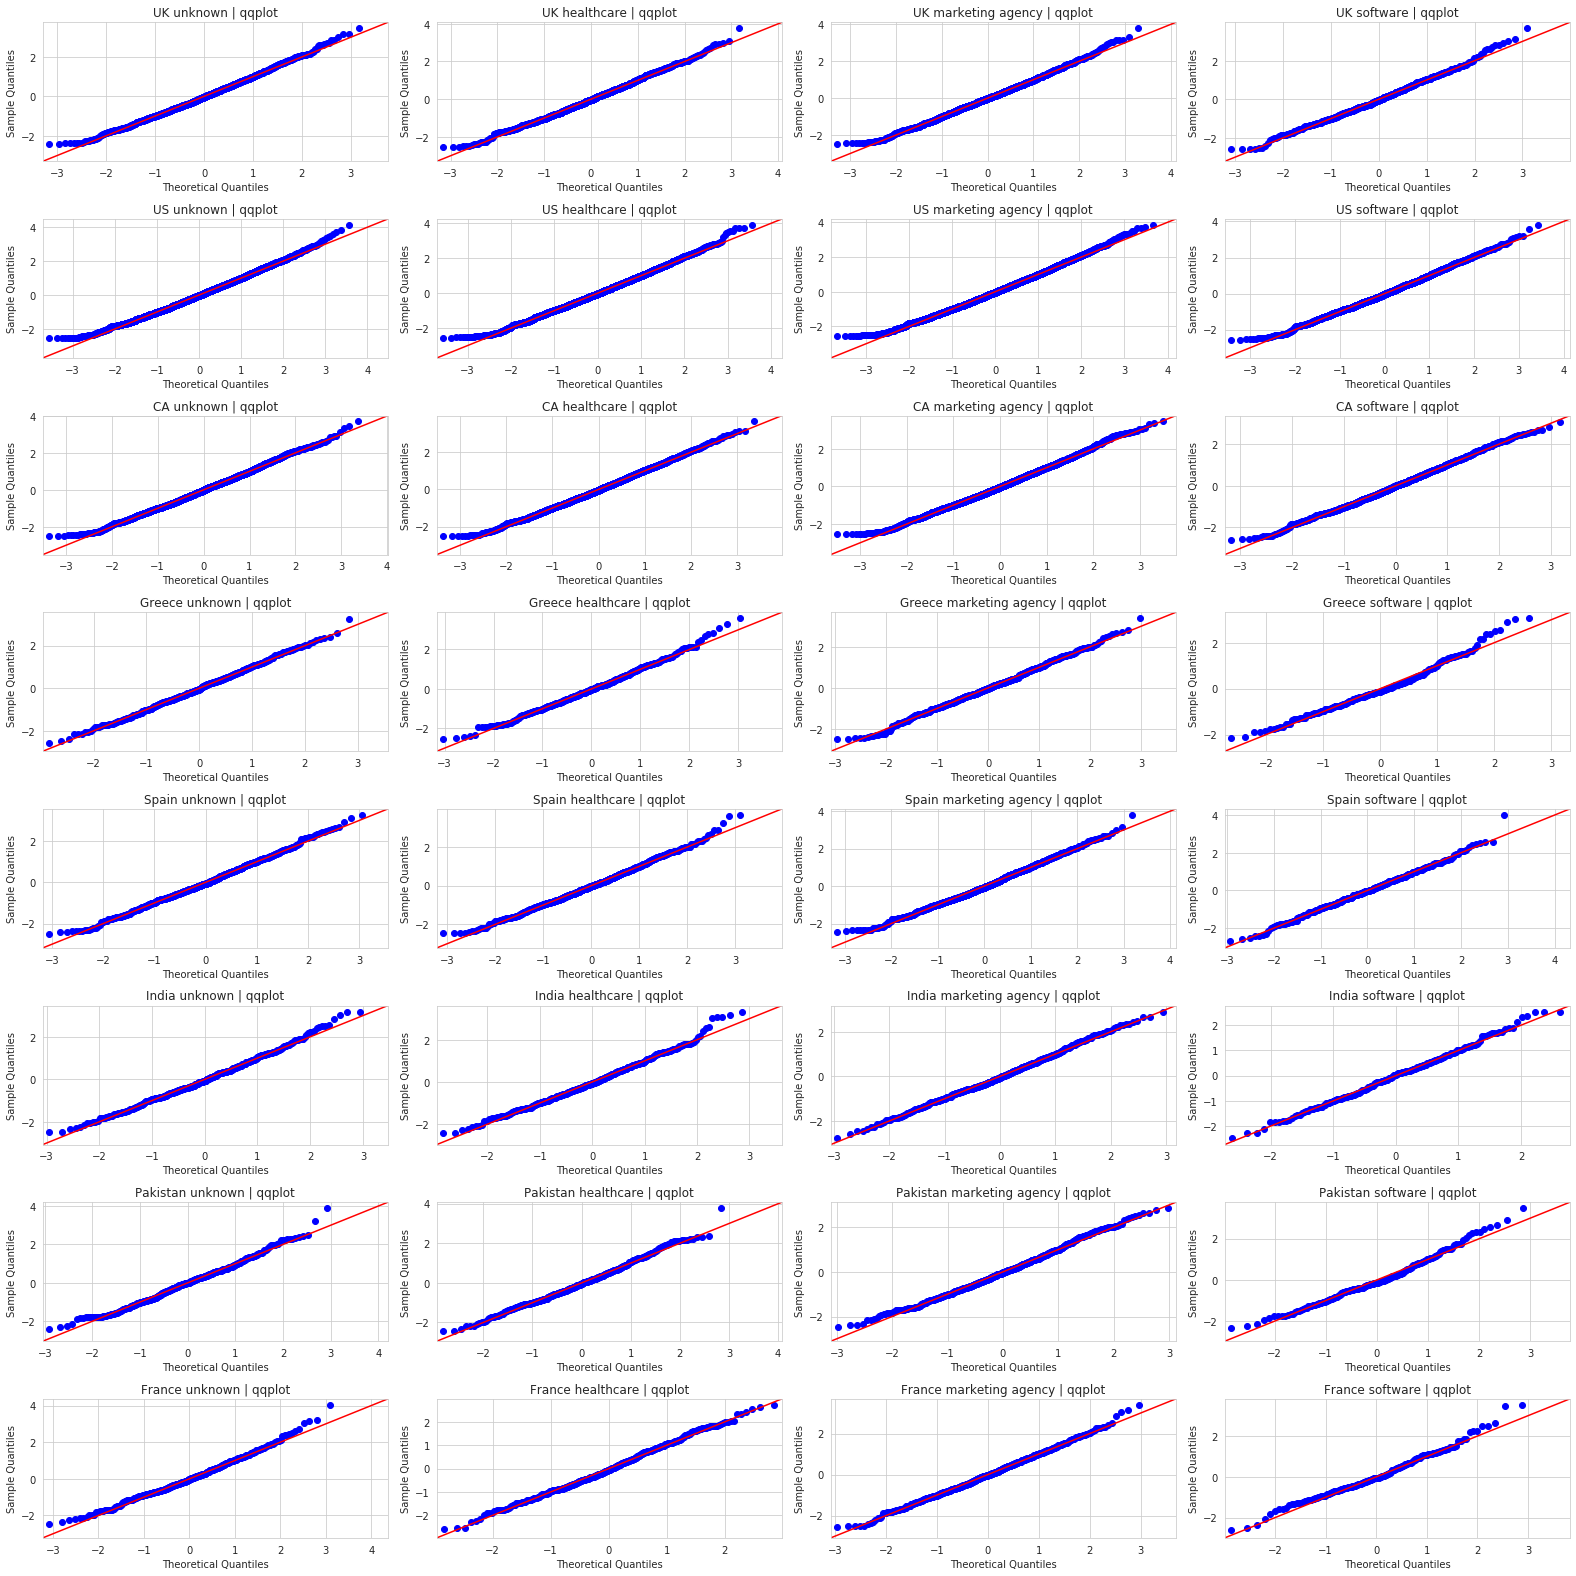

In [15]:
fig = plt.figure(figsize=[22,22])
i = 1

for g in d['geo'].unique():
    d_temp = d[d['geo']==g]
    for idx, ind in enumerate(d['ind'].unique()):
        d_ind = d_temp[d_temp['ind']==ind]
        ax = fig.add_subplot(8, 4, i)
        sm.graphics.qqplot(d_ind['paid'].values, dist=stats.t, line='45', fit=True, ax=ax)
        ax.set_title(g + ' ' + ind + ' | qqplot')
        i += 1
plt.tight_layout()

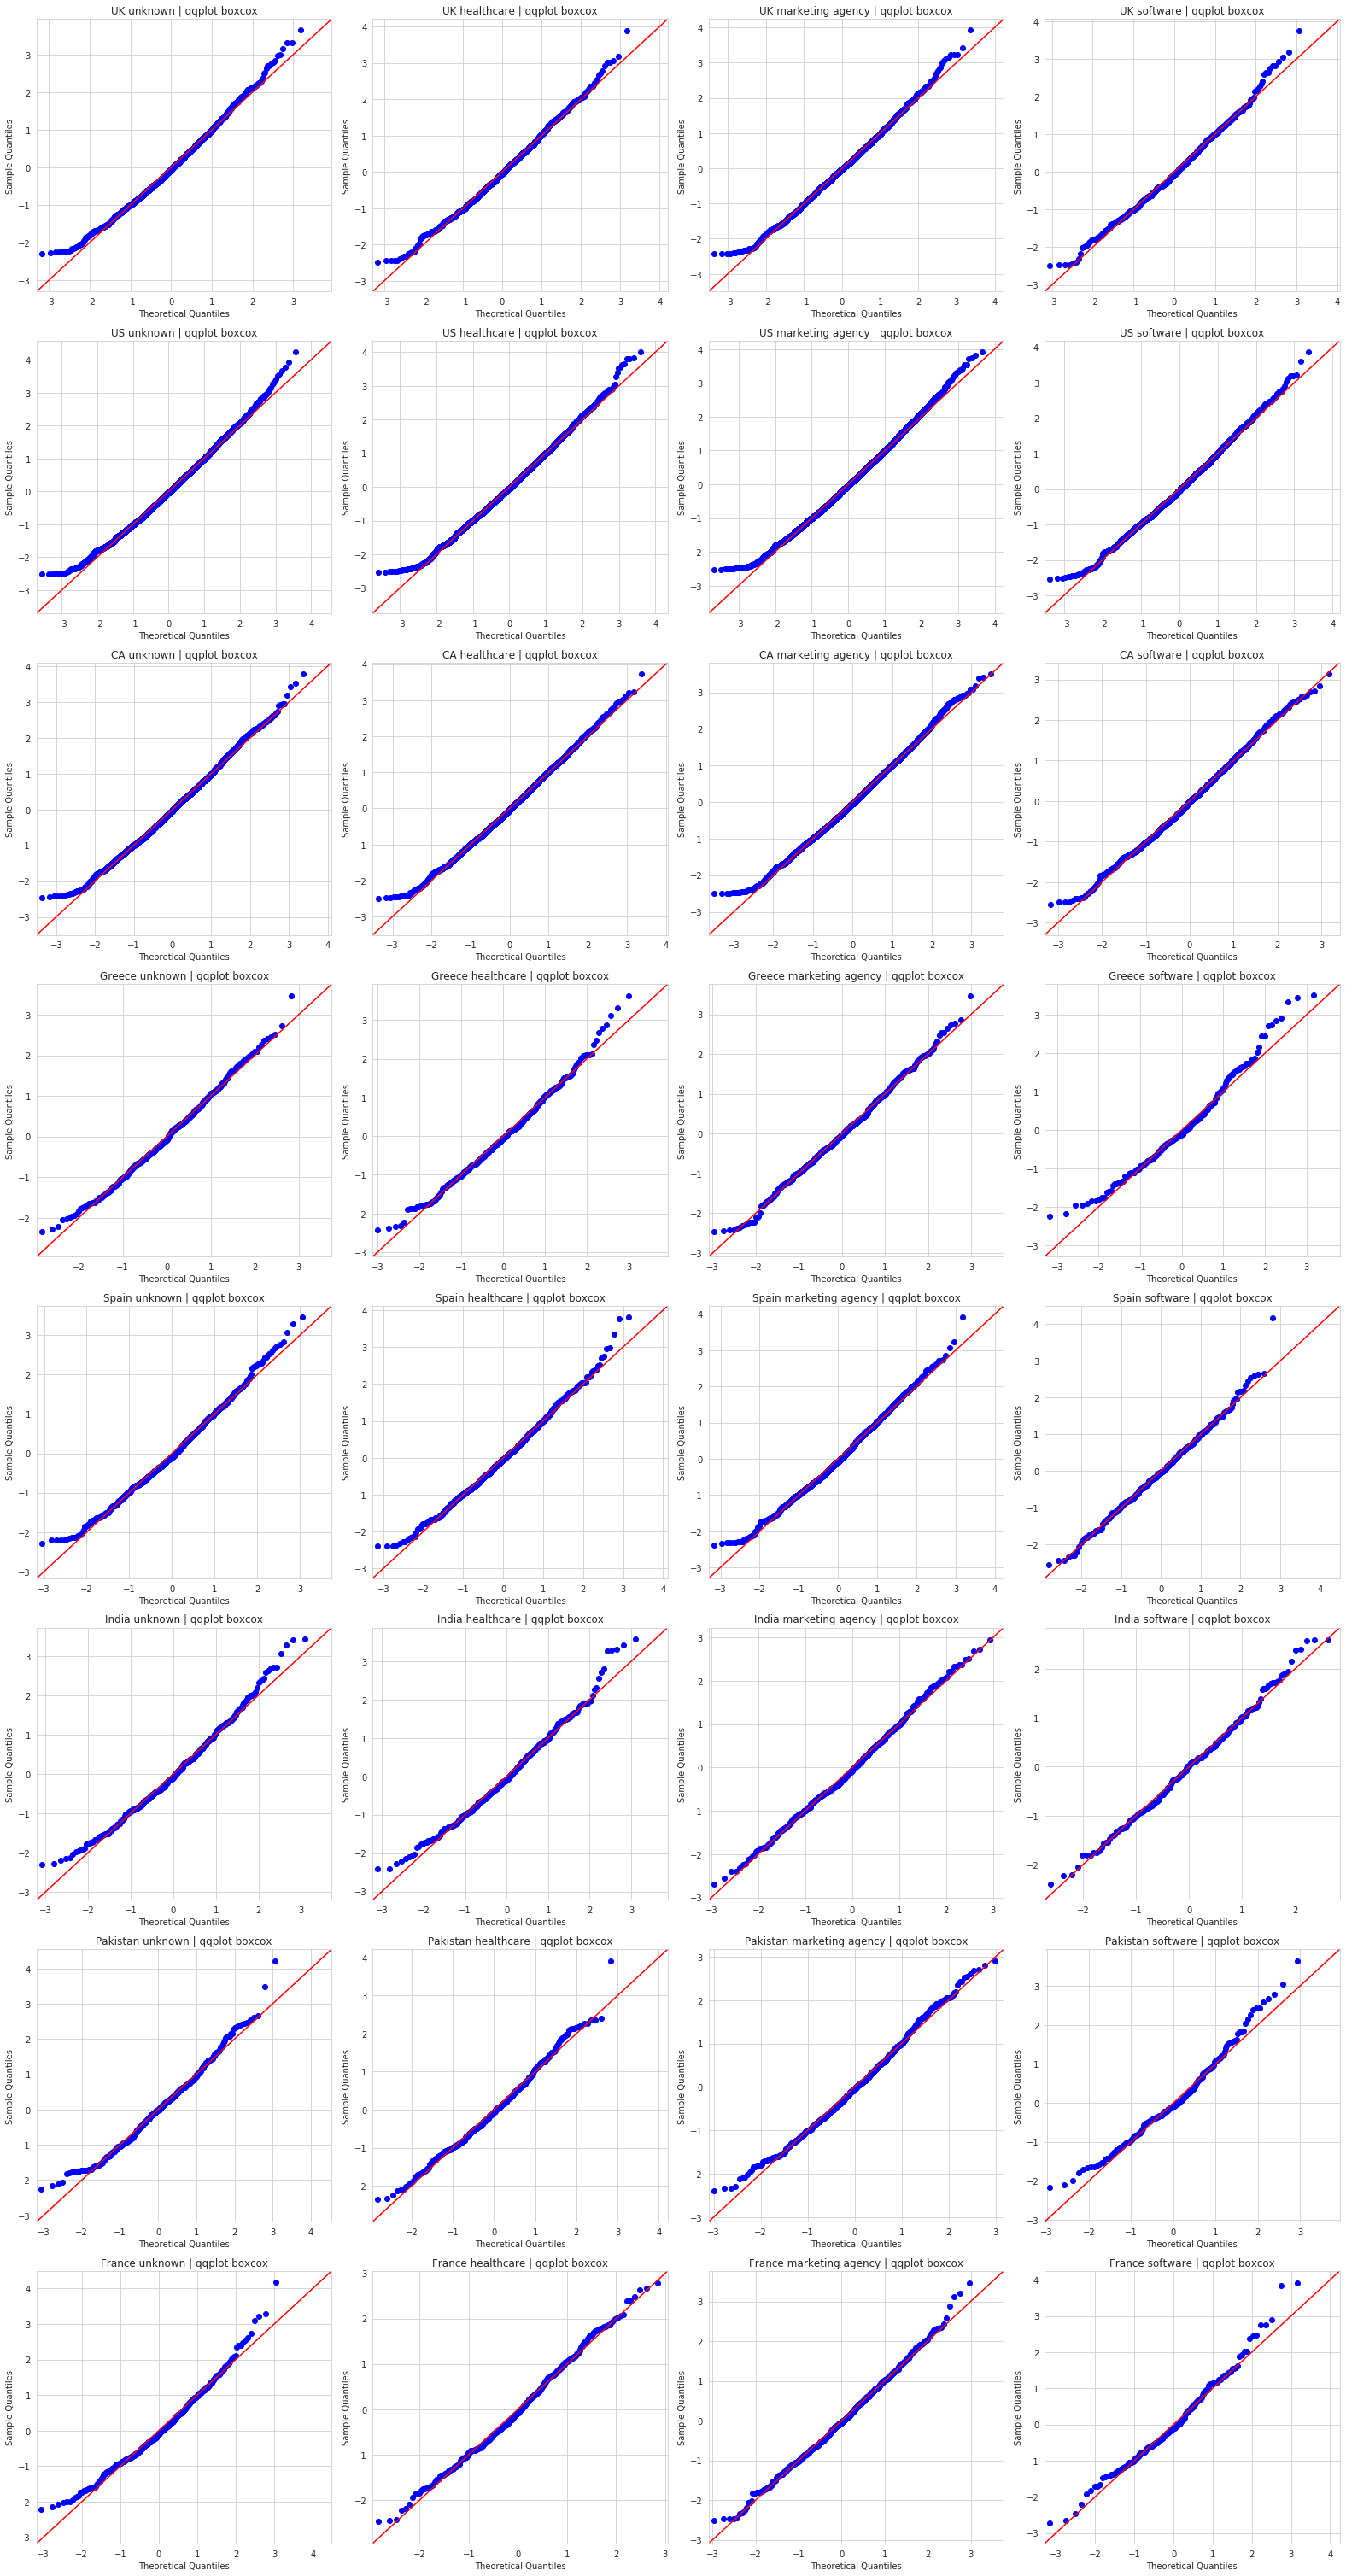

In [16]:
fig = plt.figure(figsize=[22,42])
i = 1

for g in d['geo'].unique():
    d_temp = d[d['geo']==g]
    for idx, ind in enumerate(d['ind'].unique()):
        d_ind = d_temp[d_temp['ind']==ind]
        ax = fig.add_subplot(8, 4, i)
        sm.graphics.qqplot(d_ind['paid_boxcox'].values, dist=stats.t, line='45', fit=True, ax=ax)
        ax.set_title(g + ' ' + ind + ' | qqplot boxcox')
        i += 1
plt.tight_layout()

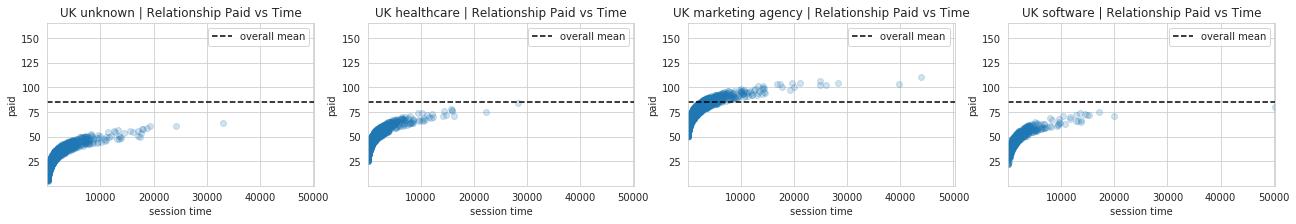

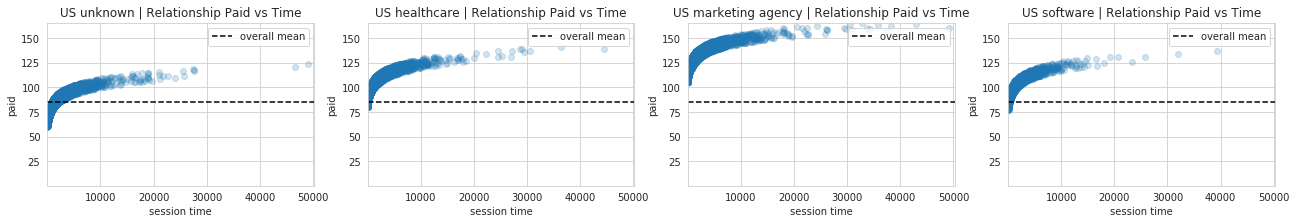

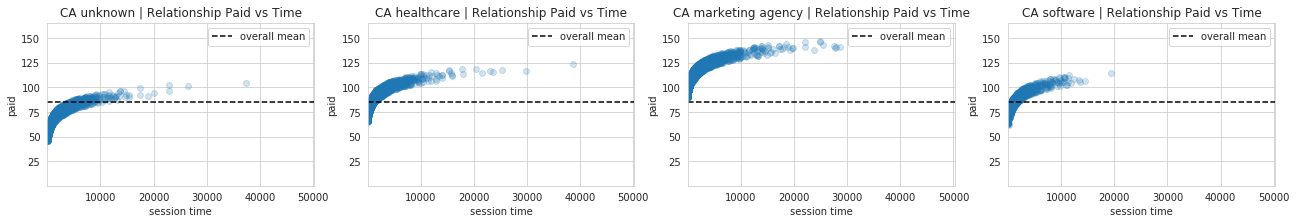

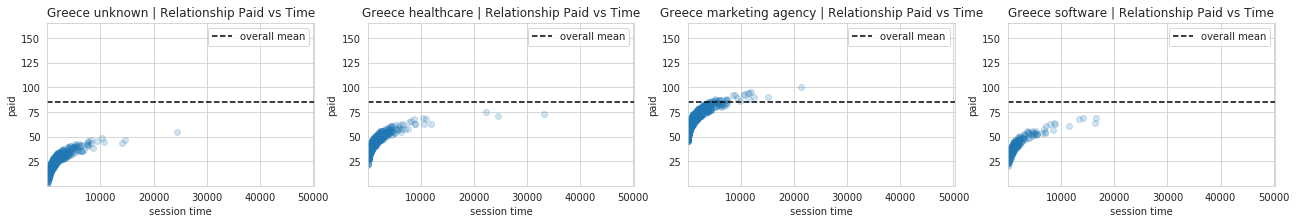

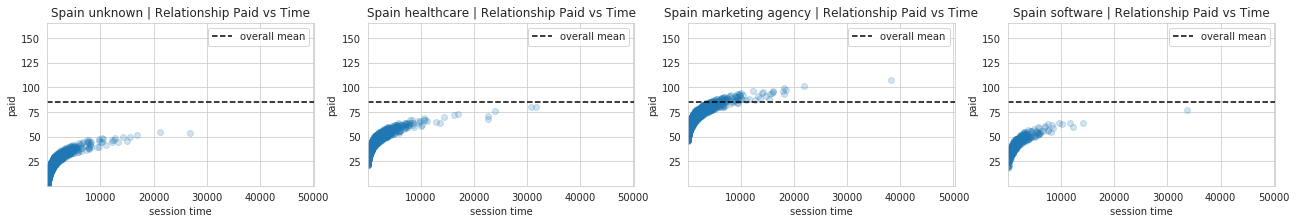

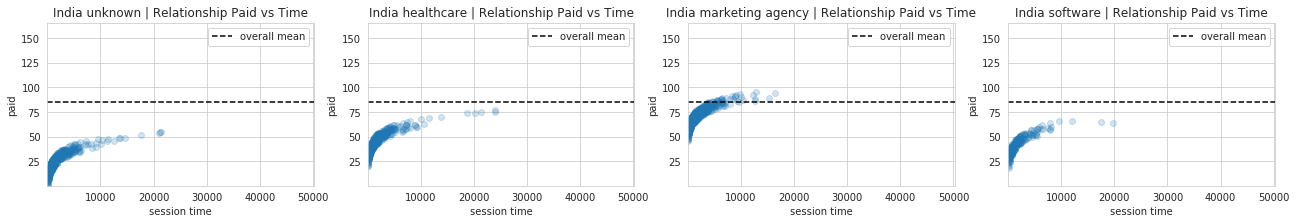

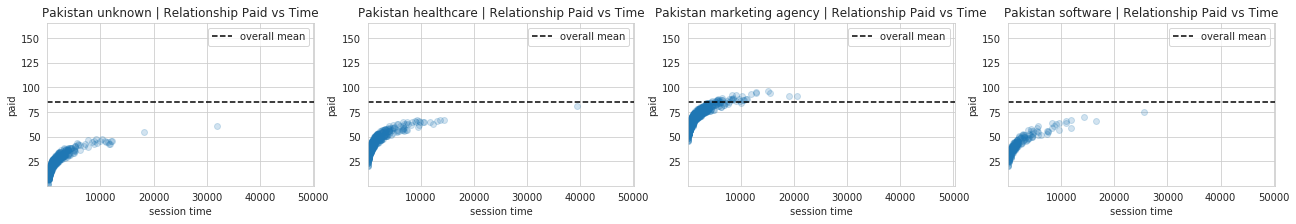

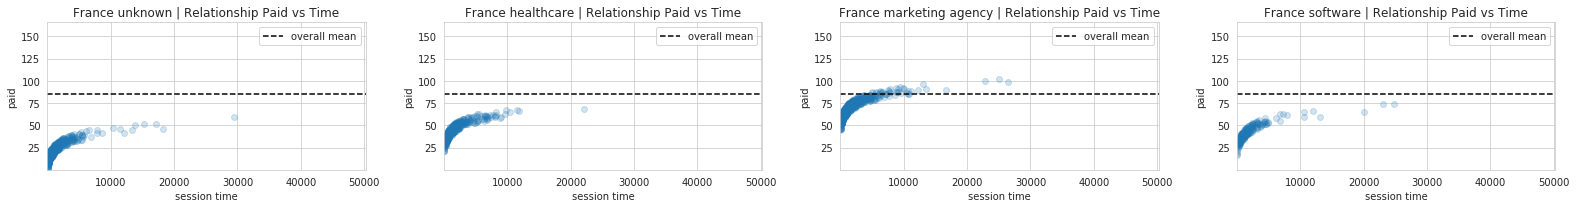

In [17]:
for g in d['geo'].unique():
    d_temp = d[d['geo']==g]
    f, ax = plt.subplots(1,len(d['ind'].unique()), figsize=[22,3])
    for idx, ind in enumerate(d['ind'].unique()):
        d_ind = d_temp[d_temp['ind']==ind]
        ax[idx].scatter(d_ind['time'], d_ind['paid'], alpha=0.2)
        ax[idx].axhline(d['paid'].mean(), ls='--', color='k', label='overall mean')
        ax[idx].set_ylim(min(d['paid']), max(d['paid']))
        ax[idx].set_xlim(min(d['time']), max(d['time']))
        ax[idx].set_title(g + ' ' + ind + ' | Relationship Paid vs Time')
        ax[idx].set_xlabel('session time')
        ax[idx].set_ylabel('paid')
        ax[idx].legend(loc='upper right')     
plt.tight_layout()

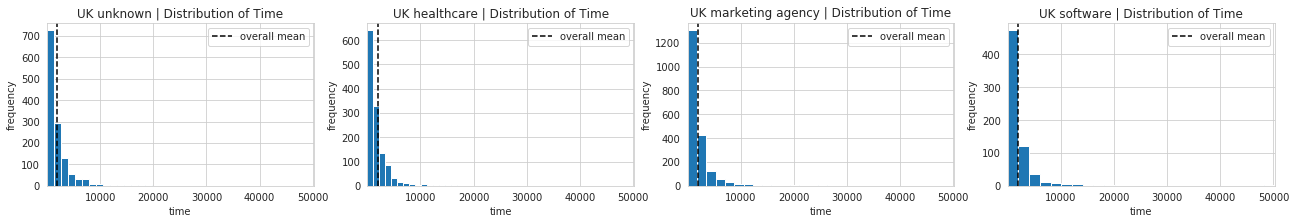

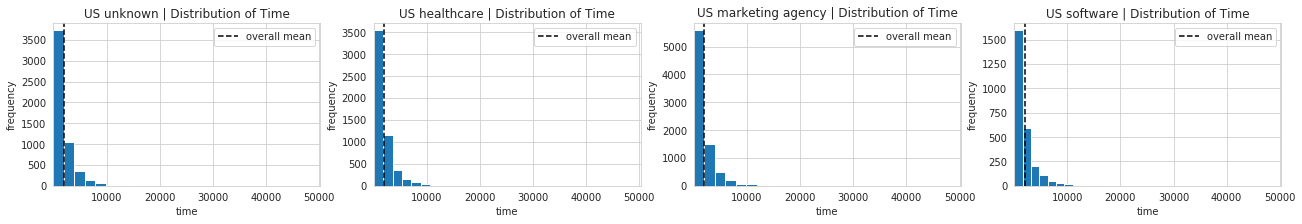

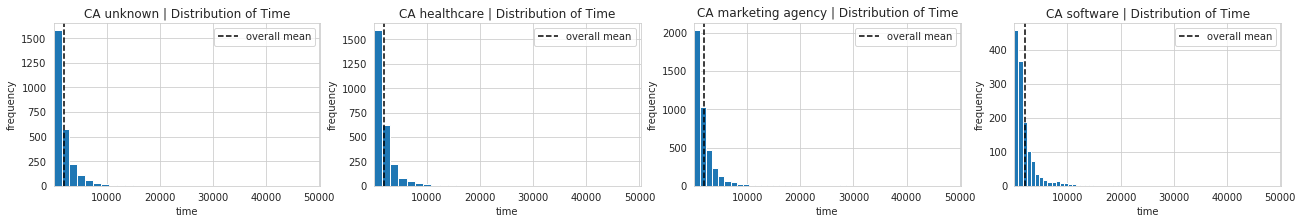

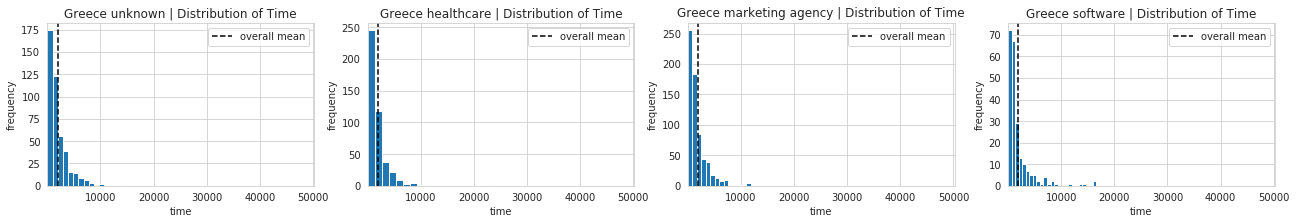

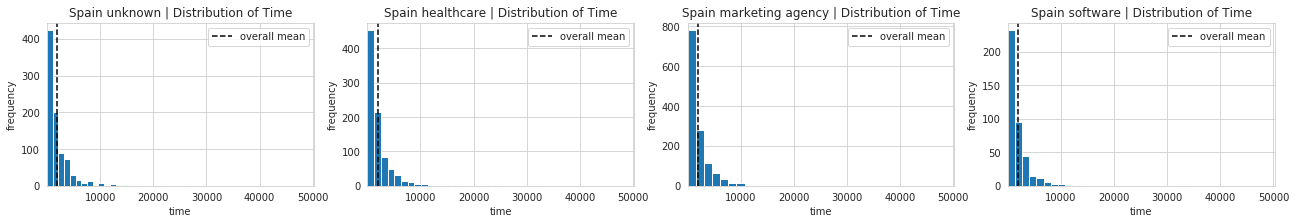

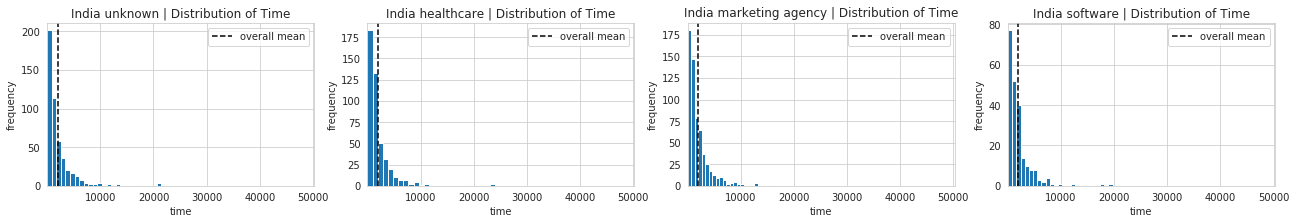

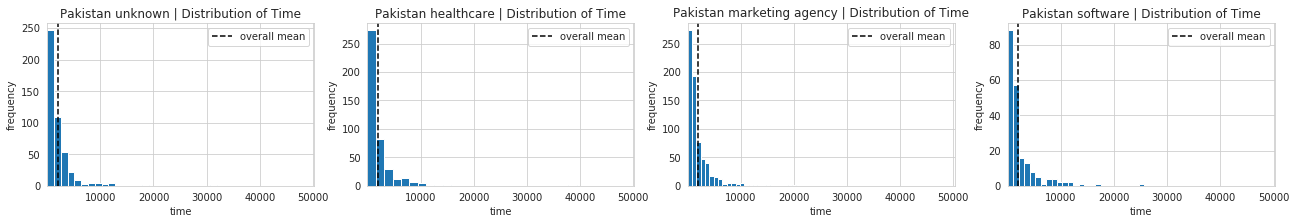

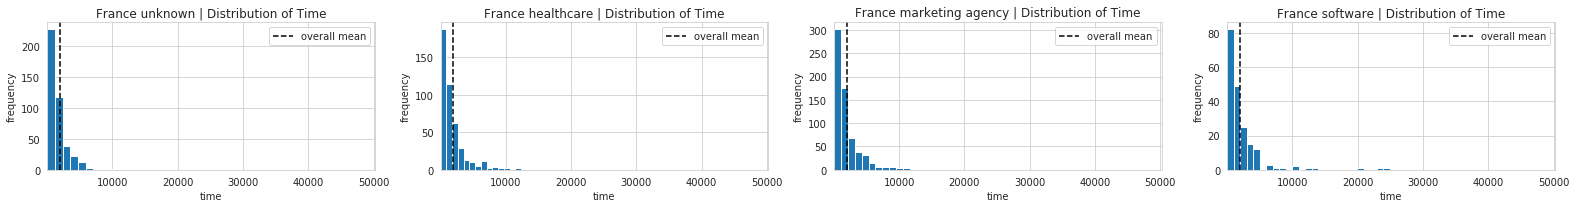

In [18]:
for g in d['geo'].unique():
    d_temp = d[d['geo']==g]
    f, ax = plt.subplots(1,len(d['ind'].unique()), figsize=[22,3])
    for idx, ind in enumerate(d['ind'].unique()):
        d_ind = d_temp[d_temp['ind']==ind]
        ax[idx].hist(d_ind['time'], bins=25)
        ax[idx].axvline(d['time'].mean(), ls='--', color='k', label='overall mean')
        ax[idx].set_xlim(min(d['time']), max(d['time']))
        ax[idx].set_title(g + ' ' + ind + ' | Distribution of Time')
        ax[idx].set_xlabel('time')
        ax[idx].set_ylabel('frequency')
        ax[idx].legend(loc='upper right')
plt.tight_layout()

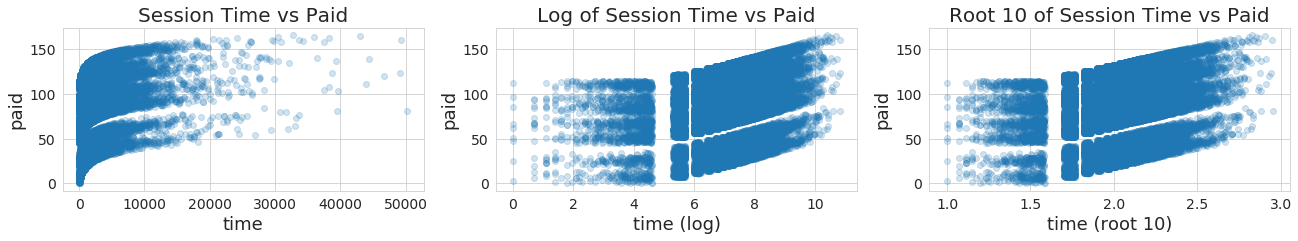

In [19]:
f, ax = plt.subplots(1,3, figsize=[22,3])
ax[0].scatter(d['time'], d['paid'], alpha=0.2)
ax[0].set_title('Session Time vs Paid', fontsize=20)
ax[0].set_ylabel('paid', fontsize=18)
ax[0].set_xlabel('time', fontsize=18)
ax[0].tick_params(labelsize=14)

ax[1].scatter(np.log(d['time']), d['paid'], alpha=0.2)
ax[1].set_title('Log of Session Time vs Paid', fontsize=20)
ax[1].set_ylabel('paid', fontsize=18)
ax[1].set_xlabel('time (log)', fontsize=18)
ax[1].tick_params(labelsize=14)

ax[2].scatter(np.power(d['time'],1/10), d['paid'], alpha=0.2)
ax[2].set_title('Root 10 of Session Time vs Paid', fontsize=20)
ax[2].set_ylabel('paid', fontsize=18)
ax[2].set_xlabel('time (root 10)', fontsize=18)
ax[2].tick_params(labelsize=14)
plt.show()

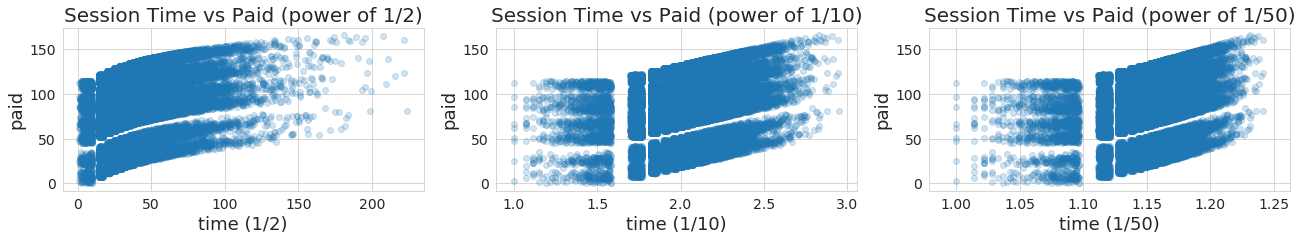

In [20]:
f, ax = plt.subplots(1,3, figsize=[22,3])
ax[0].scatter(np.power(d['time'],1/2), d['paid'], alpha=0.2)
ax[0].set_title('Session Time vs Paid (power of 1/2)', fontsize=20)
ax[0].set_ylabel('paid', fontsize=18)
ax[0].set_xlabel('time (1/2)', fontsize=18)
ax[0].tick_params(labelsize=14)

ax[1].scatter(np.power(d['time'],1/10), d['paid'], alpha=0.2)
ax[1].set_title('Session Time vs Paid (power of 1/10)', fontsize=20)
ax[1].set_ylabel('paid', fontsize=18)
ax[1].set_xlabel('time (1/10)', fontsize=18)
ax[1].tick_params(labelsize=14)

ax[2].scatter(np.power(d['time'],1/50), d['paid'], alpha=0.2)
ax[2].set_title('Session Time vs Paid (power of 1/50)', fontsize=20)
ax[2].set_ylabel('paid', fontsize=18)
ax[2].set_xlabel('time (1/50)', fontsize=18)
ax[2].tick_params(labelsize=14)
plt.show()

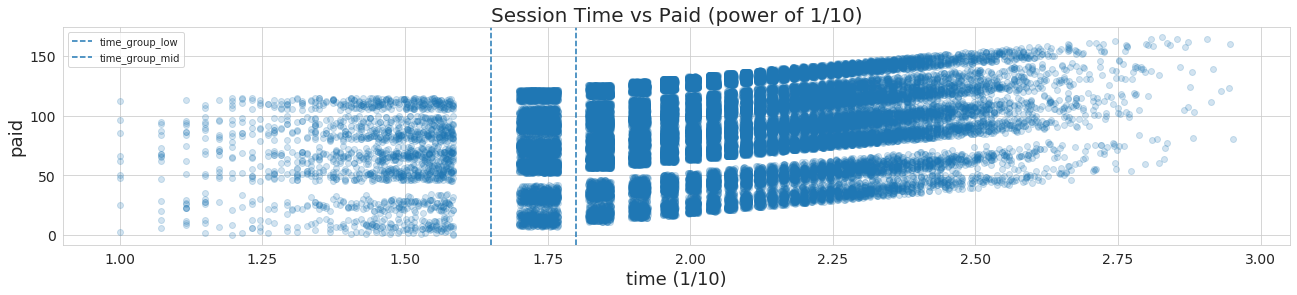

In [21]:
figsize(22,4)
plt.scatter(np.power(d['time'],1/10), d['paid'], alpha=0.2)
# plt.scatter(np.log(d['time']), d['paid'], alpha=0.2)
plt.axvline(time_group_low, ls='--', label='time_group_low')
plt.axvline(time_group_mid, ls='--', label='time_group_mid')
plt.title('Session Time vs Paid (power of 1/10)', fontsize=20)
plt.ylabel('paid', fontsize=18)
plt.xlabel('time (1/10)', fontsize=18)
plt.tick_params(labelsize=14)
plt.legend()
plt.show()

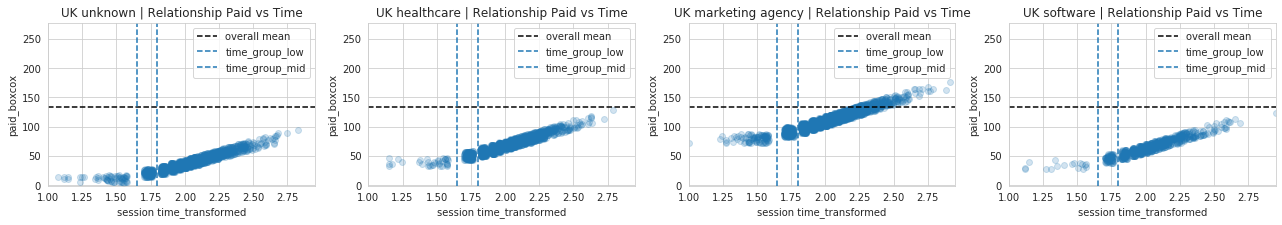

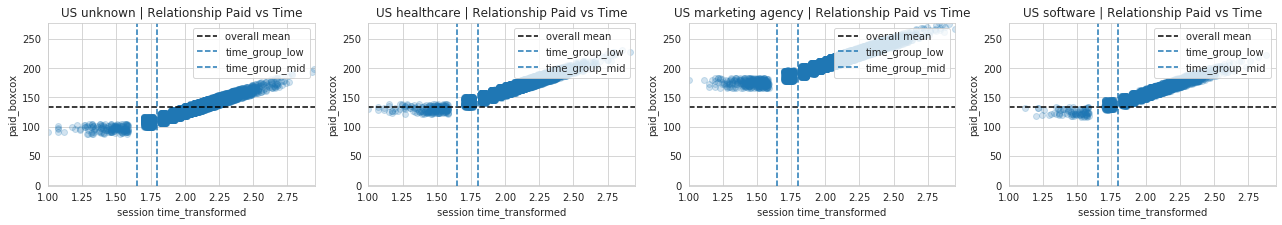

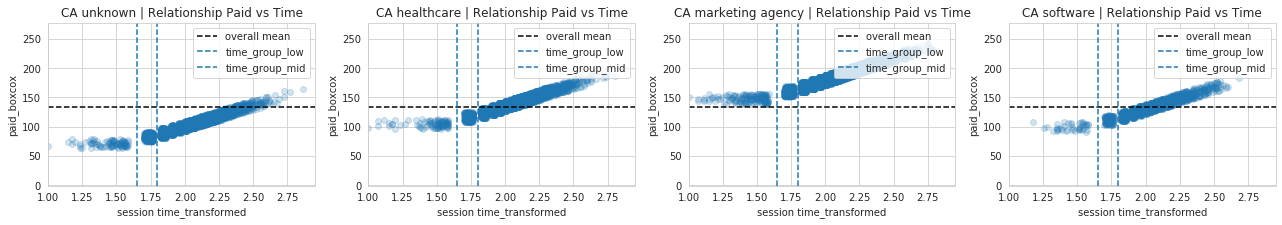

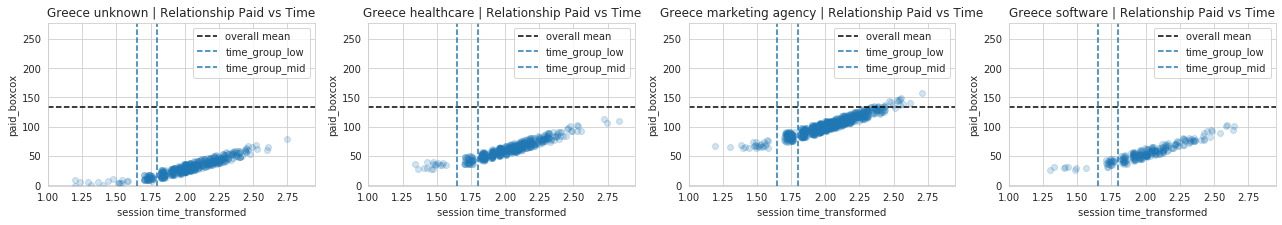

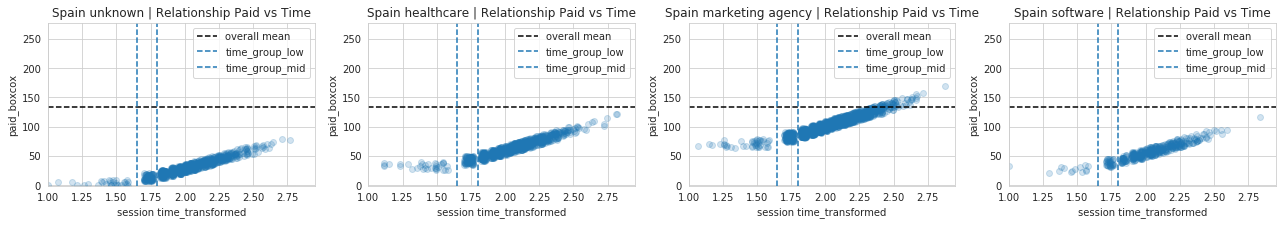

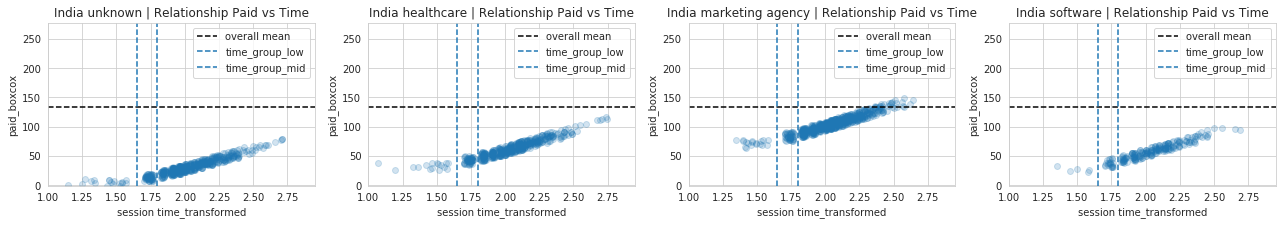

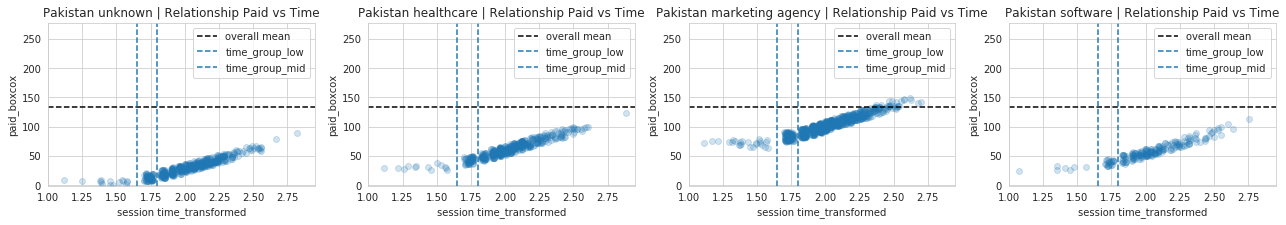

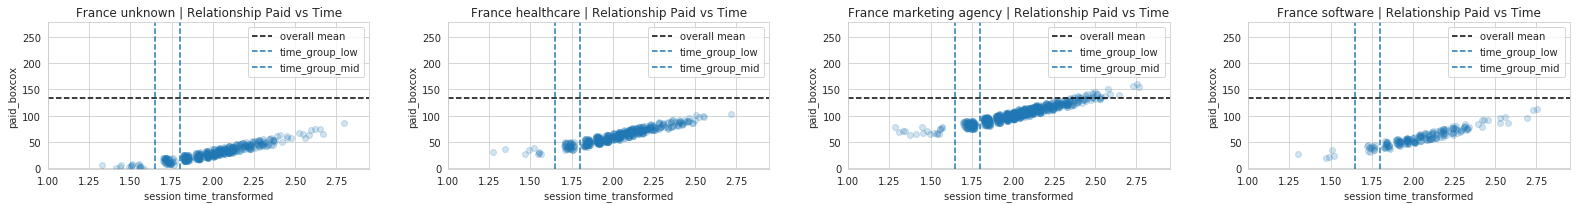

In [22]:
for g in d['geo'].unique():
    d_temp = d[d['geo']==g]
    f, ax = plt.subplots(1,len(d['ind'].unique()), figsize=[22,3])
    for idx, ind in enumerate(d['ind'].unique()):
        d_ind = d_temp[d_temp['ind']==ind]
        ax[idx].scatter(d_ind['time_transformed'], d_ind['paid_boxcox'], alpha=0.2)
        ax[idx].axhline(d['paid_boxcox'].mean(), ls='--', color='k', label='overall mean')
        ax[idx].axvline(time_group_low, ls='--', label='time_group_low')
        ax[idx].axvline(time_group_mid, ls='--', label='time_group_mid')
        ax[idx].set_ylim(min(d['paid_boxcox']), max(d['paid_boxcox']))
        ax[idx].set_xlim(min(d['time_transformed']), max(d['time_transformed']))
        ax[idx].set_title(g + ' ' + ind + ' | Relationship Paid vs Time')
        ax[idx].set_xlabel('session time_transformed')
        ax[idx].set_ylabel('paid_boxcox')
        ax[idx].legend(loc='upper right')  
plt.tight_layout()

In [23]:
#-----------------------------------------------------------------------
# Creating session time indicator variable based on linear relationship seen above
#-----------------------------------------------------------------------
d['time_group'] = 0
d['time_group'] = d['time_transformed'].apply(time_grouping)
d.head()

id               ind     geo  browser  time        paid  \
0  1585597623           unknown      UK   Chrome  1092   25.607595   
1  6531970533        healthcare      US  Firefox  2480  115.579494   
2  8443866239        healthcare      CA   Chrome  1671   89.462246   
3  1480089466        healthcare  Greece   Chrome   465   33.836123   
4  6170390298  marketing agency      US  Firefox  1477  129.394415   

   time_transformed  paid_boxcox  time_group  
0          2.012900    33.190347           2  
1          2.184968   184.606107           2  
2          2.100379   138.192452           2  
3          1.848184    45.727604           2  
4          2.074618   209.711785           2

## 2. Please create a linear regression model which estimates the prior_month_paid as a function of some (or all) of the attributes contained in the file.

### Comments

I will be using Ridge regularization to reduce overfitting and to identify the best predictors. I will create a baseline model without the "time_group" variable created above that does not include interaction terms, but includes all the predictors in the dataset. The second model will include interaction terms.

I will select the best transformation for session time using cross validation and will use this same process to select the best regularization parameter for the Ridge Regression model. Cross validation helps to measure how well models perform on unseen data and lets us average performance over multiple sets of unseen data.

In [24]:
#------------------------------------------------------------------------------------------------------
# Cross Validation to determine session time transformation, alpha for Ridge regression, and baselines
#------------------------------------------------------------------------------------------------------
storage = []
folds = KFold(n_splits=10)

for root in [0, 2, 1, 1/2, 1/5, 1/10, 1/50, 1/100]:
    #---------------------------------------------------------
    # X and y dataframe creation and cross validation
    #---------------------------------------------------------
    d['time_group'] = d['time_group'].astype(str)
    if root == 0:
        d['time_transformed'] = np.log(d['time'])
    if root != 0:
        d['time_transformed'] = np.power(d['time'], root)
    X = pd.concat([d[['time_transformed']], pd.get_dummies(d[['ind', 'geo', 'browser', 'time_group']], drop_first=True)], axis=1); 
    base_names = X.columns.values
    interactions = PolynomialFeatures(interaction_only=True, include_bias=False)
    X = interactions.fit_transform(X); 
    all_names = interactions.get_feature_names(base_names)
    X = pd.DataFrame(X, columns=all_names); X
    y = d[['paid']]; 
    
    for alpha in [1/1000, 1/500, 1/100, 1/10, 1/2, 1, 5]:
        for train_idx, val_idx in folds.split(X, y):
            X_train = X.iloc[train_idx]
            X_val = X.iloc[val_idx]
            y_train = y.iloc[train_idx]
            y_val = y.iloc[val_idx]
            
            # baseline model with no interactions and no groups for session time
            model = Ridge(alpha=alpha).fit(X_train.loc[:,['time_transformed', 'ind_marketing agency', 'ind_software',
                                                          'ind_unknown', 'geo_France', 'geo_Greece', 'geo_India', 'geo_Pakistan',
                                                          'geo_Spain', 'geo_UK', 'geo_US', 'browser_Firefox', 'browser_IE',
                                                          'browser_Safari']], y_train)
            pred = model.predict(X_val.loc[:,['time_transformed', 'ind_marketing agency', 'ind_software',
                                              'ind_unknown', 'geo_France', 'geo_Greece', 'geo_India', 'geo_Pakistan',
                                              'geo_Spain', 'geo_UK', 'geo_US', 'browser_Firefox', 'browser_IE','browser_Safari']])

            # model with interactions and session time groups
            model_interactions = Ridge(alpha=alpha).fit(X_train, y_train)
            pred_interactions = model_interactions.predict(X_val)

            storage.append({'model':'ridge',
                            'root':root,
                            'alpha':alpha,
                            'mae':mean_absolute_error(y_val, pred)})
            storage.append({'model':'ridge_interactions',
                            'root':root,
                            'alpha':alpha,
                            'mae':mean_absolute_error(y_val, pred_interactions)})
            storage.append({'model':'mean',
                            'root':0,
                          'alpha':0,
                          'mae':mean_absolute_error(y_val, np.repeat(y_train.mean(), len(y_val)))})
scores = pd.DataFrame(storage).groupby(['model', 'root', 'alpha']).mean().sort_values('mae', ascending=True).reset_index();
scores.to_csv('scores.csv', index=False); 

In [25]:
scores = pd.read_csv('scores.csv')
mae_ridge = scores[scores['model']=='ridge'].iloc[0,3]; mae_ridge
mae_ridge_interactions = scores[scores['model']=='ridge_interactions'].iloc[0,3]; mae_ridge_interactions
mae_mean = scores[scores['model']=='mean'].iloc[0,3]; mae_mean
print(f'baseline model cross validated mae: \t{mae_ridge:.2f}')
print(f'interaction model cross validated mae: \t{mae_ridge_interactions:.2f}')
print(f'mean cross validated mae: \t\t{mae_mean:.2f}')

baseline model cross validated mae: 	2.58
interaction model cross validated mae: 	2.51
mean cross validated mae: 		26.98


### Comments

The model with the best accuracy scores is the Ridge Regression model that includes interactions terms, this model scored slightly better than the model without interaction terms.

## 3. Please provide an inferential interpretation of the results of your regression model.

### Comments

For inference, I will run the model using the best transformation for session time and the best regularization parameter that was identified above.

I will then take a look at the predictors identified by the regularization and check residuals on both models and an alternative regularization parameter.

For inference on coefficients and prediction intervals, I will run this same model in a Bayesian framework so that we can see the distributions of possibilities for both.

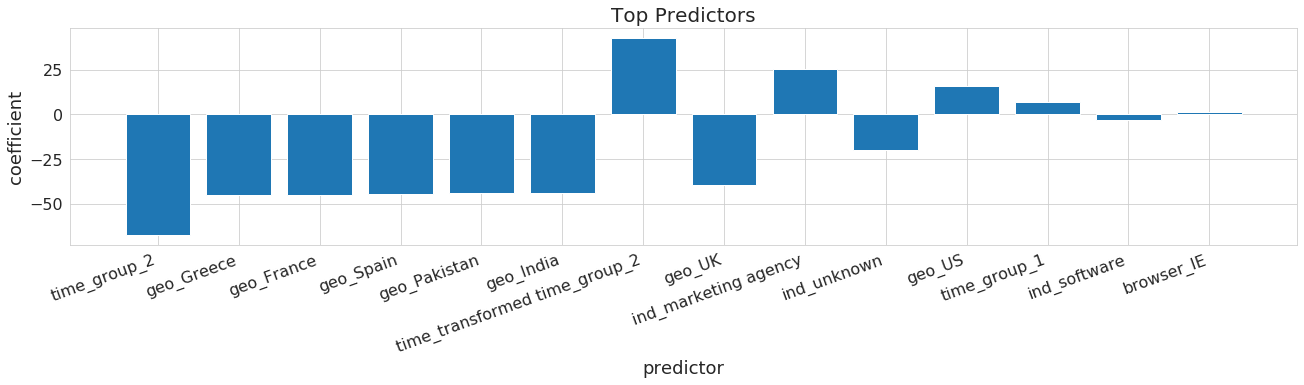

In [26]:
best_alpha = scores[scores['model']=='ridge_interactions'].loc[0, 'alpha']
best_root = scores[scores['model']=='ridge_interactions'].loc[0,'root']; best_root

#---------------------------------------------------------
# Ridge Model
#---------------------------------------------------------
d['time_group'] = d['time_group'].astype(str)
d['time_transformed'] = np.power(d['time'], best_root)
X = pd.concat([d[['time_transformed']], pd.get_dummies(d[['ind', 'geo', 'browser', 'time_group']], drop_first=True)], axis=1); 
base_names = X.columns.values
interactions = PolynomialFeatures(interaction_only=True, include_bias=False)
X = interactions.fit_transform(X); 
all_names = interactions.get_feature_names(base_names)
X = pd.DataFrame(X, columns=all_names); X
y = d[['paid']]; 

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.3, stratify=d[['ind', 'geo']])

model = Ridge(alpha=best_alpha).fit(X_train.loc[:,['time_transformed', 'ind_marketing agency', 'ind_software',
                                             'ind_unknown', 'geo_France', 'geo_Greece', 'geo_India', 'geo_Pakistan',
                                             'geo_Spain', 'geo_UK', 'geo_US', 'browser_Firefox', 'browser_IE','browser_Safari']],
                                   y_train)
model_interactions = Ridge(alpha=best_alpha).fit(X_train,y_train)
coef = pd.DataFrame(model_interactions.coef_, columns=X.columns).T; 
coef = coef.rename(columns={0:'coefficient'}); coef
mask = [np.abs(c) > 0.95 for c in coef['coefficient']]
coef = coef[mask]; len(coef)
coef['abs'] = np.abs(coef['coefficient'])
coef = coef.sort_values('abs', ascending=False)
figsize(22,4)
plt.bar(range(len(coef)), coef['coefficient'])
plt.xticks(ticks=range(len(coef)), labels=coef.index, rotation=20, ha='right')
plt.tick_params(labelsize=16)
plt.title('Top Predictors', fontsize=20)
plt.ylabel('coefficient', fontsize=18)
plt.xlabel('predictor', fontsize=18)
plt.show()

### Comments

Above we see the predictors with coefficients that the ridge regularization identified for the model that included interactions. The other predictors have coefficients close to zero, meaning that they do not have much of an impact on predictions.

What we see confirms what we saw in the EDA plots, geography is strongly related to the amount paid, as is industry, and session time at the higher levels has positive relationship to paid, meaning that as session time increases for this group, the level paid increases.

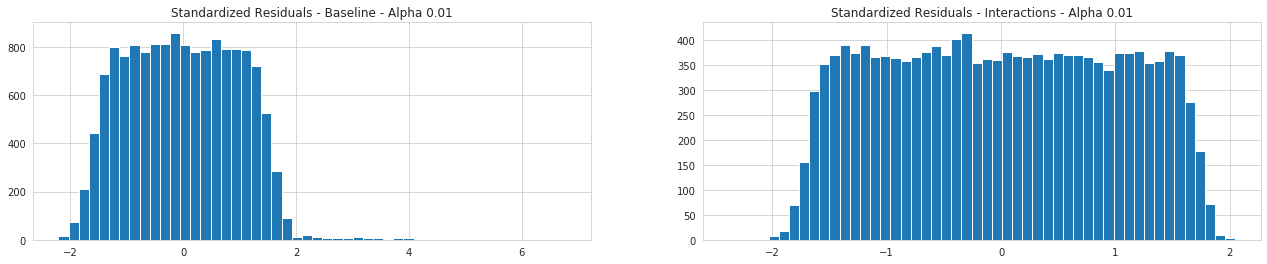

In [27]:
#----------------------------------------------------------------------------
# Residuals - Best Alpha (higher regularization)
#----------------------------------------------------------------------------
y_hat = model.predict(X_val.loc[:,['time_transformed', 'ind_marketing agency', 'ind_software',
                               'ind_unknown', 'geo_France', 'geo_Greece', 'geo_India', 'geo_Pakistan',
                               'geo_Spain', 'geo_UK', 'geo_US', 'browser_Firefox', 'browser_IE','browser_Safari']])
residuals = y_val - y_hat
residuals = residuals.values.reshape(-1); residuals
residuals_std = (residuals - residuals.mean()) / residuals.std(); 

y_hat_interactions = model_interactions.predict(X_val)
residuals_interactions = y_val - y_hat_interactions
residuals_interactions = residuals_interactions.values.reshape(-1); 
residuals_std_interactions = (residuals_interactions - residuals_interactions.mean()) / residuals_interactions.std(); 

f, ax = plt.subplots(1,2, figsize=[22,4])
ax[0].hist(residuals_std, bins=50); ax[0].set_title(f'Standardized Residuals - Baseline - Alpha {best_alpha:.2f}')
ax[1].hist(residuals_std_interactions, bins=50); ax[1].set_title(f'Standardized Residuals - Interactions - Alpha {best_alpha:.2f}')
plt.show()

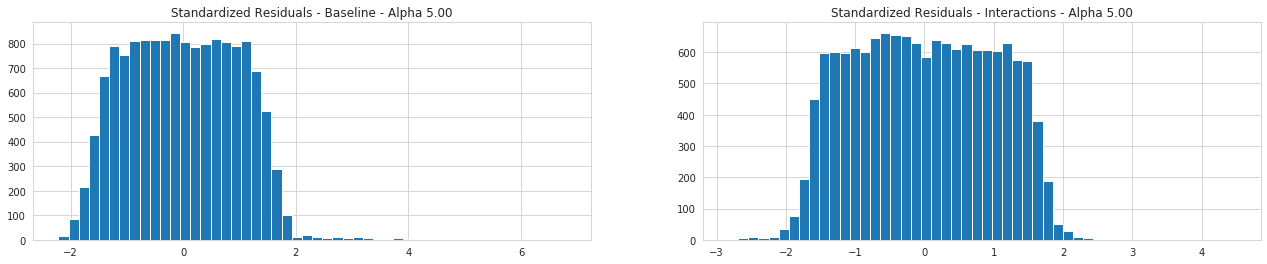

In [28]:
#----------------------------------------------------------------------------
# Residuals - Alternative Alpha
#----------------------------------------------------------------------------
alpha = 5
model = Ridge(alpha=alpha).fit(X_train.loc[:,['time_transformed', 'ind_marketing agency', 'ind_software',
                                             'ind_unknown', 'geo_France', 'geo_Greece', 'geo_India', 'geo_Pakistan',
                                             'geo_Spain', 'geo_UK', 'geo_US', 'browser_Firefox', 'browser_IE','browser_Safari']],
                                   y_train)
model_interactions = Ridge(alpha=alpha).fit(X_train,y_train)

y_hat = model.predict(X_val.loc[:,['time_transformed', 'ind_marketing agency', 'ind_software',
                               'ind_unknown', 'geo_France', 'geo_Greece', 'geo_India', 'geo_Pakistan',
                               'geo_Spain', 'geo_UK', 'geo_US', 'browser_Firefox', 'browser_IE','browser_Safari']])
residuals = y_val - y_hat
residuals = residuals.values.reshape(-1); residuals
residuals_std = (residuals - residuals.mean()) / residuals.std(); 

y_hat_interactions = model_interactions.predict(X_val)
residuals_interactions = y_val - y_hat_interactions
residuals_interactions = residuals_interactions.values.reshape(-1); 
residuals_std_interactions = (residuals_interactions - residuals_interactions.mean()) / residuals_interactions.std(); 

f, ax = plt.subplots(1,2, figsize=[22,4])
ax[0].hist(residuals_std, bins=50); ax[0].set_title(f'Standardized Residuals - Baseline - Alpha {alpha:.2f}')
ax[1].hist(residuals_std_interactions, bins=50); ax[1].set_title(f'Standardized Residuals - Interactions - Alpha {alpha:.2f}')
plt.show()

### Comments

Above we see that the model using interaction terms and a regularization parameter of 0.01 performs the best as it does not have standardized residuals greater or less than two. Residuals past these levels means there were accounts that the model struggled to predict and these accounts may be influential data points that skew predictions.

We do not see residual distributions that look normal, this is one of the reasons to use a Bayesian framework for inference on prediction intervals as this assumption of normal residuals is not necessary to create prediction intervals.

In [29]:
#----------------------------------------------------------------------------------------
# Bayesian Ridge Model
#----------------------------------------------------------------------------------------
mask = [c in coef.index for c in X.columns]
X_bayes = X.iloc[:, mask]
y_bayes = y.values.reshape(-1)

with pm.Model() as model_bayes:
    x_shared = pm.Data('x_shared', X_bayes)
    
    α = pm.Normal('α', mu=0, sigma=10)
    β_mu = pm.Normal('β_mu', mu=0, sigma=10)
    β_sigma = pm.HalfCauchy('β_sigma', beta=10)
    β = pm.Normal('β', mu=β_mu, sigma=β_sigma, shape=X_bayes.shape[1])
    
    μ = α + pm.math.dot(x_shared, β)
    σ = pm.HalfCauchy('σ', beta=10)
    
    paid = pm.Normal('paid', mu=μ, sigma=σ, observed=y_bayes)
    trace = pm.sample(1000, tune=1000, chains=4, target_accept=0.95)
pm.save_trace(trace, directory='trace.trace', overwrite=True)
trace = pm.load_trace('trace.trace', model=model_bayes); 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, β_sigma, β_mu, α]
Sampling 4 chains: 100%|██████████| 8000/8000 [19:11<00:00,  6.95draws/s]  
The acceptance probability does not match the target. It is 0.9993866960283018, but should be close to 0.95. Try to increase the number of tuning steps.


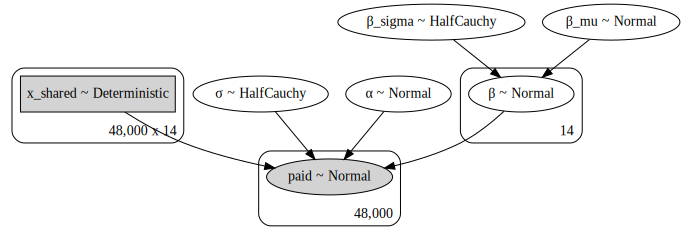

In [30]:
pm.model_to_graphviz(model_bayes)

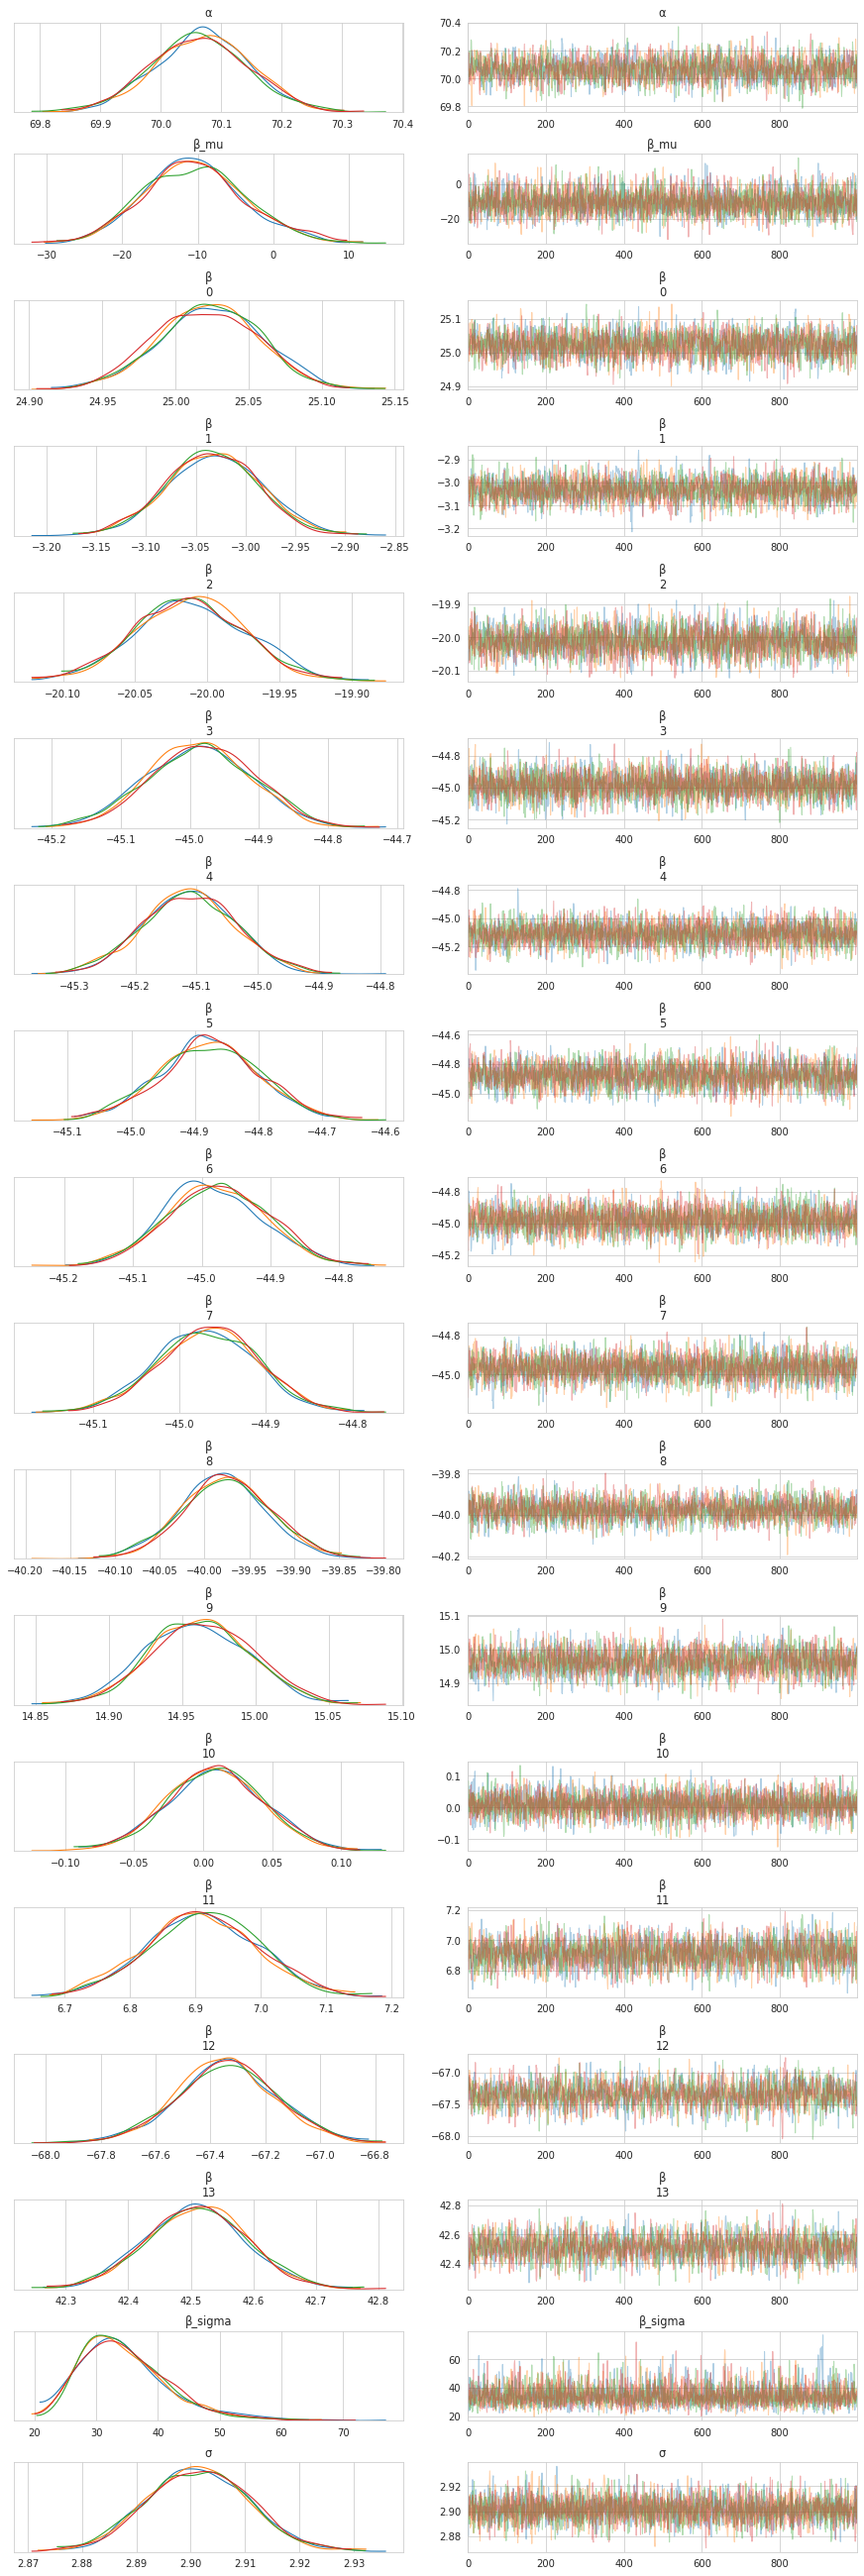

In [31]:
pm.plot_trace(trace); plt.show()

In [32]:
# pm.plot_posterior(trace); plt.show()

In [33]:
trace_summary = pm.summary(trace)
trace_summary = trace_summary.rename(index=dict(zip(list(trace_summary.index[2:16].values), list(X_bayes.columns.values))));
trace_summary

mean        sd  mc_error    hpd_2.5  \
α                              70.066649  0.078946  0.001600  69.911554   
β_mu                          -10.362298  6.691065  0.095098 -23.232138   
ind_marketing agency           25.022963  0.034862  0.000652  24.953694   
ind_software                   -3.032287  0.046661  0.000787  -3.128236   
ind_unknown                   -20.011647  0.038126  0.000664 -20.086106   
geo_France                    -44.984199  0.075617  0.001164 -45.126048   
geo_Greece                    -45.111417  0.075256  0.001376 -45.257609   
geo_India                     -44.876845  0.077403  0.001352 -45.020534   
geo_Pakistan                  -44.978699  0.072657  0.001260 -45.115341   
geo_Spain                     -44.967294  0.057404  0.001068 -45.086546   
geo_UK                        -39.976260  0.048586  0.001048 -40.069758   
geo_US                         14.962602  0.034441  0.000806  14.899371   
browser_IE                      0.008946  0.034406  0.000451  -0.055574   
time_group_1                    6.911680  0.084327  0.001574   6.737238   
time_group_2                  -67.341100  0.181189  0.004043 -67.698197   
time_transformed time_group_2  42.509479  0.080411  0.001607  42.343299   
β_sigma                        34.649399  7.244528  0.120034  21.897068   
σ                               2.901445  0.009401  0.000135   2.882813   

                                hpd_97.5        n_eff      Rhat  
α                              70.219422  2422.617331  1.000750  
β_mu                            3.090406  3904.040614  0.999544  
ind_marketing agency           25.090380  2844.825050  1.001321  
ind_software                   -2.945302  2850.078762  1.000824  
ind_unknown                   -19.937166  2787.264384  1.000557  
geo_France                    -44.835478  3814.868307  1.001312  
geo_Greece                    -44.960040  3060.749094  1.000066  
geo_India                     -44.717702  2790.235724  1.000195  
geo_Pakistan                  -44.832423  3261.205002  1.001827  
geo_Spain                     -44.862060  2986.685693  1.001277  
geo_UK                        -39.879710  2344.726517  1.001998  
geo_US                         15.032797  1808.195374  1.002024  
browser_IE                      0.077495  4428.418637  1.000132  
time_group_1                    7.069071  2444.227280  1.000710  
time_group_2                  -66.987819  2086.540222  0.999944  
time_transformed time_group_2  42.659170  2428.292231  0.999892  
β_sigma                        48.926032  3395.107509  0.999925  
σ                               2.919420  5145.290962  0.999934

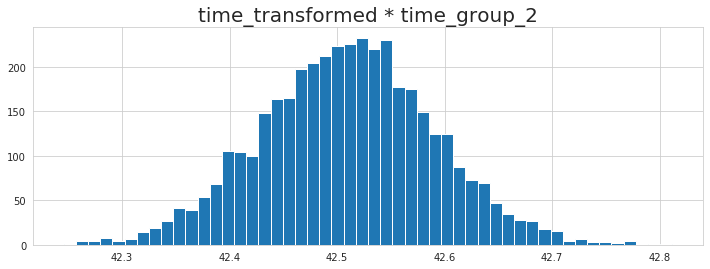

In [34]:
figsize(12,4)
plt.hist(pd.DataFrame(trace['β'], columns=X_bayes.columns)['time_transformed time_group_2'], bins=50); 
plt.title('time_transformed * time_group_2', fontsize=20)
plt.show()

### Comments

Above we see the Bayesian output on the coefficients from the Ridge Regression model with interaction terms. Some of these have distributions that cross zero so there is a chance they do not have an impact on amount paid. The others show a low level of uncertainty in their imporartance. 

## 4. Please run your model against the test data set, and describe it’s performance.

In [35]:
#--------------------------------------------------------
# Function to perform the cleaning identified through EDA
#--------------------------------------------------------
def clean_data(data, best_root=1/10):
    data = data.rename(columns={'industry':'ind', 'geography':'geo', 'most_common_browser':'browser',
                          'session_time_prior_month_seconds':'time', 'prior_month_paid':'paid'})
    
    data['time_transformed'] = np.power(data['time'], best_root)
    data['ind'] = data['ind'].replace(to_replace=['health care'], value='healthcare')
    data['ind'] = data['ind'].replace(to_replace=['Marketing Agency', 'mktg agency'], value='marketing agency')
    data['ind'] = data['ind'].replace(to_replace=['unk'], value='unknown')
    data['ind'] = data['ind'].fillna(value='unknown')
    data['geo'] = data['geo'].replace(to_replace=['USA', 'America', 'United States'], value='US')
    data['geo'] = data['geo'].replace(to_replace=['Canada'], value='CA')
    data['geo'] = data['geo'].replace(to_replace=['GB', 'United Kingdom', 'England'], value='UK')
    data['geo'] = data['geo'].replace(to_replace=['Esp'], value='Spain')

    data['time_group'] = 0
    data['time_group'] = data['time_transformed'].apply(time_grouping)
    data['time_group'] = data['time_group'].astype(str)

    X = pd.concat([data[['time_transformed']], pd.get_dummies(data[['ind', 'geo', 'browser', 'time_group']], drop_first=True)], axis=1); 
    base_names = X.columns.values
    interactions = PolynomialFeatures(interaction_only=True, include_bias=False)
    X = interactions.fit_transform(X); 
    all_names = interactions.get_feature_names(base_names)
    X = pd.DataFrame(X, columns=all_names)
    y = data[['paid']]
    return data, X, y

In [36]:
coef.index

Index(['time_group_2', 'geo_Greece', 'geo_France', 'geo_Spain', 'geo_Pakistan',
       'geo_India', 'time_transformed time_group_2', 'geo_UK',
       'ind_marketing agency', 'ind_unknown', 'geo_US', 'time_group_1',
       'ind_software', 'browser_IE'],
      dtype='object')

In [37]:
X_bayes.columns

Index(['ind_marketing agency', 'ind_software', 'ind_unknown', 'geo_France',
       'geo_Greece', 'geo_India', 'geo_Pakistan', 'geo_Spain', 'geo_UK',
       'geo_US', 'browser_IE', 'time_group_1', 'time_group_2',
       'time_transformed time_group_2'],
      dtype='object')

In [38]:
X_test_bayes.columns

NameError: name 'X_test_bayes' is not defined

In [39]:
#--------------------------------------------------------------------
# Cleaning test data and calculating Mean Absolute Error
#--------------------------------------------------------------------
d_test, X_test, y_test = clean_data(t)

#-------------------------------------------------------------
# Generating samples of possible amounts paid on the test set
#------------------------------------------------------------
mask = [c in coef.index for c in X_test.columns]
X_test_bayes = X_test.iloc[:, mask]
y_test_bayes = y_test.values.reshape(-1)

with model_bayes:
    pm.set_data({'x_shared': X_test_bayes})
    y_ppc = pm.sample_posterior_predictive(trace, 1000)

pred = np.mean(y_ppc['paid'], axis=0)
lower = np.percentile(y_ppc['paid'], 2.5, axis=0); lower
upper = np.percentile(y_ppc['paid'], 97.5, axis=0); upper

d_test['y_test_bayes'] = pred
d_test['y_test_lower'] = lower
d_test['y_test_upper'] = upper

d_test['y_test_pred'] = pred
mae_test = mean_absolute_error(y_test_bayes, pred)
print(f'Mean Absolute Error on the test set: {mae_test:.2f}')

100%|██████████| 1000/1000 [00:02<00:00, 380.69it/s]


Mean Absolute Error on the test set: 2.52


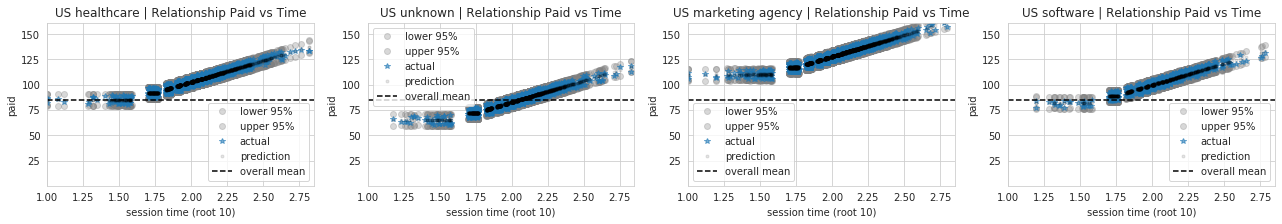

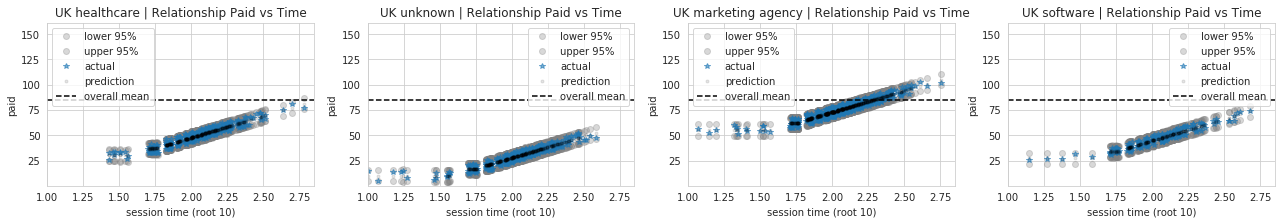

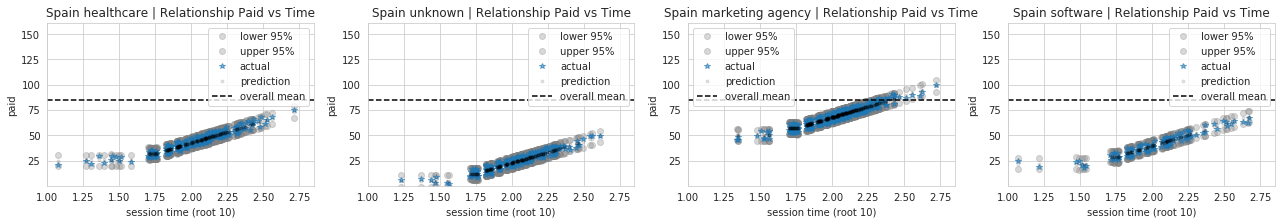

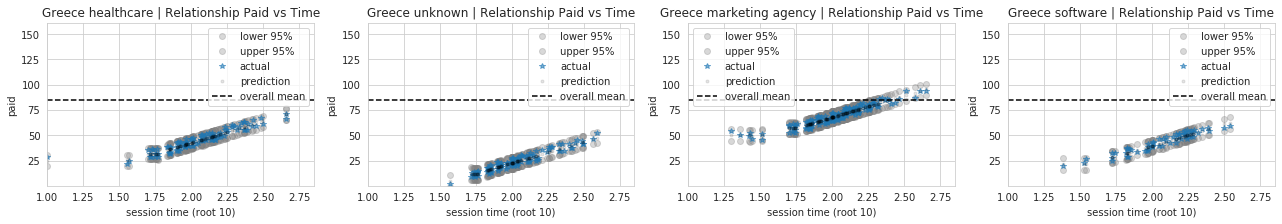

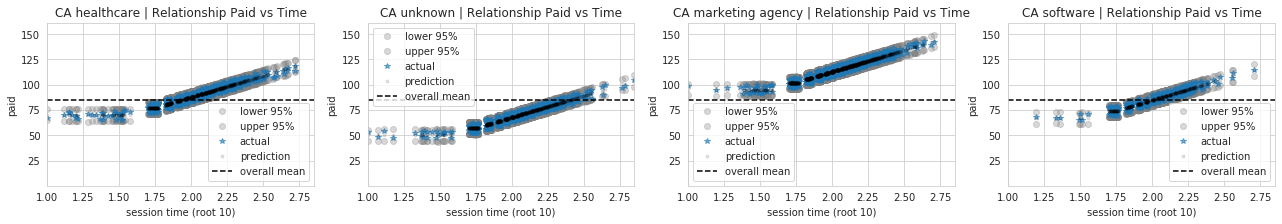

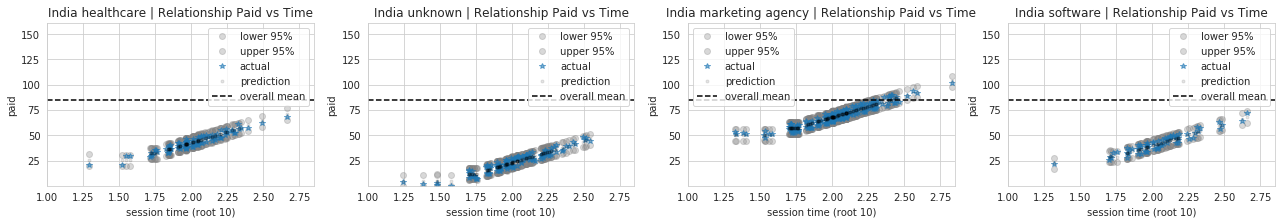

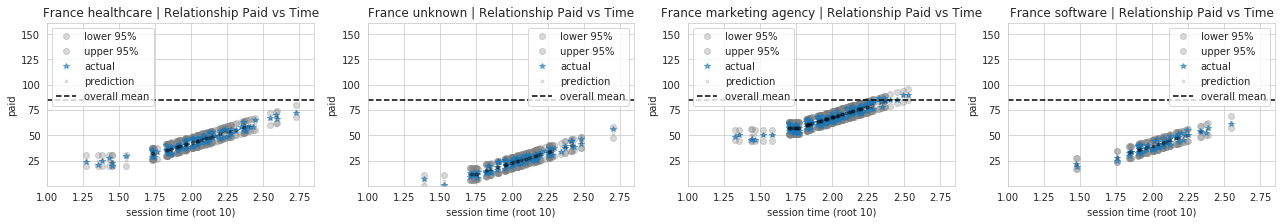

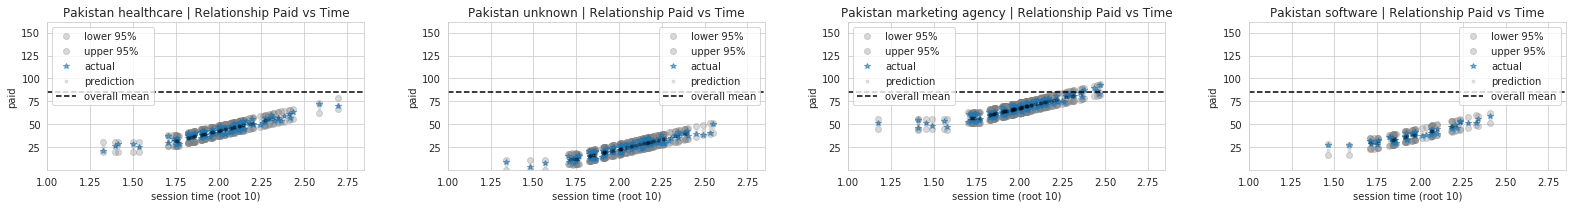

In [40]:
#-----------------------------------------------------------------------
# Plotting the model results for the test set verses actual amounts paid
#--------------------------------------------------------------------
for g in d_test['geo'].unique():
    d_temp = d_test[d_test['geo']==g]
    f, ax = plt.subplots(1,len(d_test['ind'].unique()), figsize=[22,3])
    for idx, ind in enumerate(d_test['ind'].unique()):
        d_ind = d_temp[d_temp['ind']==ind]
        # plot intervals
        ax[idx].plot(d_ind['time_transformed'], d_ind['y_test_lower'], alpha=0.3, color='gray', ls='', marker='o', label='lower 95%')
        ax[idx].plot(d_ind['time_transformed'], d_ind['y_test_upper'], alpha=0.3, color='gray', ls='', marker='o', label='upper 95%')
        ax[idx].plot(d_ind['time_transformed'], d_ind['paid'], alpha=0.6, ls='', marker='*', label='actual')
        ax[idx].plot(d_ind['time_transformed'], d_ind['y_test_bayes'], alpha=0.1, color='k', ls='', marker='.', label='prediction')
        ax[idx].axhline(d_test['paid'].mean(), ls='--', color='k', label='overall mean')
        ax[idx].set_ylim(min(d_test['paid']), max(d_test['paid']))
        ax[idx].set_xlim(min(d_test['time_transformed']), max(d_test['time_transformed']))
        ax[idx].set_title(g + ' ' + ind + ' | Relationship Paid vs Time')
        ax[idx].set_xlabel('session time (root 10)')
        ax[idx].set_ylabel('paid')
        ax[idx].legend()     
plt.tight_layout()

### Comments

Above we see the 95% Bayesian Credible Interval in gray, which tells us that the model is saying there is a 95% probability the actual amount paid will be within the bounds of the gray dots. The black dots show us the predictions of the model, which do a good job fitting the pattern of the actual amounts paid. The blue stars show the actual amount paid.

## 5. What would your recommended next steps for the business be?

### Comments

In general, I would want to have discussions with different stake holders in the business to understand what questions, goals, or business problems they want to address with this analysis, before making recommendations.

If determining fees for customers is currently a manual process, it would be reasonalbe to consider automating this process based on the patterns identified by the model that match closely with what we see in the data.

The primary predictors of the amount paid is based on geography and industry, I would want to talk with business stakeholders to understand if this is the intention. I would suspect that there are other services or products being delelivered that are tied to the amount paid and not represented in this dataset, but there use is tied closely to geography and industry so these two predictors are capturing those relationships to amount paid.